In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')

%matplotlib inline

### Überblick über den Datensatz

Der analysierte Datensatz besteht aus bereinigten und feature-engineerten Transaktionsdaten und enthält sowohl numerische als auch kategoriale Merkmale. Die Struktur ist konsistent, vollständig und für eine weitere Modellierung geeignet.

Die Trennung zwischen Eingangsmerkmalen und Zielvariable (`FraudResult`) ist klar definiert, wodurch potenzielles Data Leakage vermieden wird. Insgesamt stellt der Datensatz eine stabile Grundlage für die nachfolgenden Analyse- und Modellierungsschritte dar.


In [42]:
Data_PATH = "../data/processed/training_preprocessed.csv"

df = pd.read_csv(Data_PATH)

# Erste 5 Zeilen zeigen (nur für einen ersten Eindruck)
print("📋 Erste 5 Transaktionen:")
display(df.head())

print("\n" + "="*70)
print("📊 VOLLSTÄNDIGER ÜBERBLICK: Vielfalt im gesamten Datensatz")
print("="*70)
print(f"Anzahl Transaktionen: {len(df):,}")
print(f"Anzahl Features: {len(df.columns)}\n")

# Anzahl eindeutiger Werte pro Spalte
print("Anzahl verschiedener Werte je Feature:")
print("-" * 70)
nunique_df = df.nunique().to_frame(name='Anzahl eindeutiger Werte').sort_values(by='Anzahl eindeutiger Werte', ascending=False)
display(nunique_df)

print("\n" + "="*70)
print("📈 KATEGORISCHE FEATURES: Häufigkeitsverteilungen")
print("="*70)

# Für jedes kategorische Feature die Werte in Tabellenform zeigen
categorical_cols = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']

for col in categorical_cols:
    print(f"\n{'='*70}")
    print(f"📊 {col}")
    print('='*70)
    
    # value_counts als DataFrame mit Anzahl und Prozent
    counts = df[col].value_counts()
    percent = df[col].value_counts(normalize=True) * 100
    
    result_df = pd.DataFrame({
        'Wert': counts.index,
        'Anzahl': counts.values,
        'Anteil (%)': percent.values.round(2)
    }).reset_index(drop=True)
    
    display(result_df)

📋 Erste 5 Transaktionen:


,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,ts_month,ts_is_weekend,ts_is_night,ts_hour_sin,ts_hour_cos,ts_dow_sin,ts_dow_cos,log_value,amount_value_ratio
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.908755,0.999001
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,3.044522,0.952381
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.216606,0.998004
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,9.989711,0.917389
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,6.469250,0.998450



📊 VOLLSTÄNDIGER ÜBERBLICK: Vielfalt im gesamten Datensatz
Anzahl Transaktionen: 95,456
Anzahl Features: 17

Anzahl verschiedener Werte je Feature:
----------------------------------------------------------------------


,Anzahl eindeutiger Werte
Amount,1676
amount_value_ratio,1668
log_value,1517
Value,1517
ProductId,23
ts_hour_cos,22
ts_hour_sin,21
ProductCategory,9
ts_dow_cos,7
ts_dow_sin,7



📈 KATEGORISCHE FEATURES: Häufigkeitsverteilungen

📊 ProviderId


,Wert,Anzahl,Anteil (%)
0,ProviderId_4,38180,40.00
1,ProviderId_6,34058,35.68
2,ProviderId_5,14498,15.19
3,ProviderId_1,5632,5.90
4,ProviderId_3,3070,3.22
5,ProviderId_2,18,0.02



📊 ProductId


,Wert,Anzahl,Anteil (%)
0,ProductId_6,32628,34.18
1,ProductId_3,24249,25.40
2,ProductId_10,15340,16.07
3,ProductId_15,11927,12.49
4,ProductId_1,2883,3.02
5,ProductId_4,2401,2.52
6,ProductId_21,1507,1.58
7,ProductId_11,1377,1.44
8,ProductId_19,955,1.00
9,ProductId_14,787,0.82



📊 ProductCategory


,Wert,Anzahl,Anteil (%)
0,financial_services,45359,47.52
1,airtime,44884,47.02
2,utility_bill,1915,2.01
3,data_bundles,1612,1.69
4,tv,1268,1.33
5,ticket,216,0.23
6,movies,175,0.18
7,transport,25,0.03
8,other,2,0.00



📊 ChannelId


,Wert,Anzahl,Anteil (%)
0,ChannelId_3,56738,59.44
1,ChannelId_2,37132,38.90
2,ChannelId_5,1048,1.10
3,ChannelId_1,538,0.56



📊 PricingStrategy


,Wert,Anzahl,Anteil (%)
0,2,79671,83.46
1,4,13546,14.19
2,1,1854,1.94
3,0,385,0.40


In [55]:
# ===== DATA QUALITY CHECK =====
print("="*70)
print("🔍 DATA QUALITY: Überprüfung der Datenqualität")
print("="*70)

# 1. Fehlende Werte
print("\n1️⃣  Fehlende Werte:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   ✅ Keine fehlenden Werte! Datensatz ist vollständig.")
else:
    print(missing[missing > 0])

# 2. Duplikate
print("\n2️⃣  Duplikate:")
duplicates = df.duplicated().sum()
if duplicates == 0:
    print("   ✅ Keine Duplikate gefunden!")
else:
    print(f"   ⚠️  {duplicates} Duplikate gefunden")

# 3. Datentypen
print("\n3️⃣  Datentypen:")
print(df.dtypes)

# 4. Wertebereich-Check
print("\n4️⃣  Wertebereich (numerische Features):")
print(df[['Amount', 'Value', 'log_value']].describe())

print("\n✅ Datenqualität geprüft - bereit für Analyse!")

🔍 DATA QUALITY: Überprüfung der Datenqualität

1️⃣  Fehlende Werte:
   ✅ Keine fehlenden Werte! Datensatz ist vollständig.

2️⃣  Duplikate:
   ⚠️  57603 Duplikate gefunden

3️⃣  Datentypen:
ProviderId             object
ProductId              object
ProductCategory        object
ChannelId              object
Amount                float64
Value                   int64
PricingStrategy         int64
FraudResult             int64
ts_month                int64
ts_is_weekend           int64
ts_is_night             int64
ts_hour_sin           float64
ts_hour_cos           float64
ts_dow_sin            float64
ts_dow_cos            float64
log_value             float64
amount_value_ratio    float64
risk_category          object
dtype: object

4️⃣  Wertebereich (numerische Features):
             Amount         Value     log_value
count  9.545600e+04  9.545600e+04  95456.000000
mean   6.722119e+03  9.911071e+03      6.974096
std    1.234393e+05  1.232543e+05      2.146935
min   -1.000000e+06  2

### Analyse der Zielvariable (FraudResult)

Die Zielvariable weist eine stark unausgeglichene Klassenverteilung auf, wobei betrügerische Transaktionen nur einen sehr kleinen Anteil des Datensatzes ausmachen. Dieses Verhalten ist typisch für reale Betrugserkennungsprobleme.

Der beobachtete Klassenimbalance macht deutlich, dass klassische Metriken wie Accuracy ungeeignet sind. Stattdessen werden im weiteren Verlauf spezialisierte Metriken sowie geeignete Trainingsstrategien erforderlich sein.


,Anzahl,Anteil (%)
FraudResult,,
0,95263,99.798
1,193,0.202


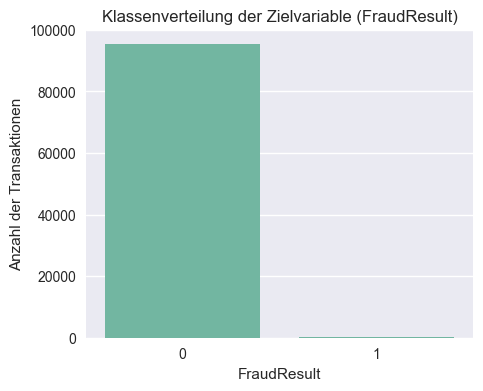

Baseline-Accuracy (immer Mehrheitsklasse): 99.80%


In [43]:
# Analyse der Zielvariable: FraudResult

TARGET = "FraudResult"

# Absolute Verteilung
counts = df[TARGET].value_counts().sort_index()

# Relative Verteilung
proportions = df[TARGET].value_counts(normalize=True).sort_index() * 100

summary = pd.DataFrame({
    "Anzahl": counts,
    "Anteil (%)": proportions.round(3)
})

display(summary)

# Visualisierung der Klassenverteilung
plt.figure(figsize=(5, 4))
sns.countplot(x=TARGET, data=df)
plt.title("Klassenverteilung der Zielvariable (FraudResult)")
plt.xlabel("FraudResult")
plt.ylabel("Anzahl der Transaktionen")
plt.show()

# Baseline Accuracy (Mehrheitsklasse)
baseline_acc = counts.max() / len(df) * 100
print(f"Baseline-Accuracy (immer Mehrheitsklasse): {baseline_acc:.2f}%")


### ⚠️ Warum ist Accuracy irreführend?

Die **Baseline-Accuracy von 99.8%** klingt beeindruckend, ist aber bei unausgeglichenen Datensätzen **völlig irreführend**!

**Problem:** Ein "dummes" Modell, das **immer "kein Betrug"** vorhersagt, erreicht:
- ✅ **99.8% Accuracy** (sieht super aus!)
- ❌ **0% Recall** (findet keinen einzigen Betrüger!)

**Warum?** Von 95,456 Transaktionen sind 95,263 (99.8%) normal. Wenn das Modell immer "normal" sagt, ist es in 99.8% der Fälle richtig – aber **völlig nutzlos**, weil es keinen Betrug erkennt!

**Analogie:** Sicherheitskontrolle am Flughafen lässt alle durch → 99.8% "Erfolgsquote", aber alle Gefährlichen kommen auch durch! ❌

### ✅ Bessere Metriken für unausgeglichene Daten:

Statt Accuracy verwenden wir:
- **Recall (Sensitivität)**: Wie viele echte Betrüger finden wir? → Von 193 Betrügern, wie viele erwischen wir?
- **Precision (Präzision)**: Von allen als "Betrug" markierten, wie viele sind echt? → Wie viele Fehlalarme?
- **F1-Score**: Harmonisches Mittel von Precision und Recall → Balance zwischen beiden
- **AUC-ROC**: Gesamtleistung über alle Schwellwerte hinweg

Diese Metriken zeigen die **echte** Leistung bei der Betrugserkennung!

In [44]:
# Berechnung besserer Metriken für das "dumme Baseline-Modell"
# (Das Modell sagt immer "kein Betrug" voraus)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Das "dumme" Modell: Vorhersage = immer 0 (kein Betrug)
y_true = df[TARGET]  # Echte Werte
y_pred_dummy = [0] * len(df)  # Vorhersage: immer 0

print("="*70)
print("📊 METRIKEN FÜR DAS 'DUMME' BASELINE-MODELL")
print("   (Modell sagt immer: 'kein Betrug')")
print("="*70)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_dummy)
print("\nConfusion Matrix:")
print(f"                Vorhergesagt: 0    Vorhergesagt: 1")
print(f"Tatsächlich 0:      {cm[0,0]:>6}           {cm[0,1]:>6}")
print(f"Tatsächlich 1:      {cm[1,0]:>6}           {cm[1,1]:>6}")

# Metriken berechnen
accuracy = (cm[0,0] + cm[1,1]) / len(df)
recall = recall_score(y_true, y_pred_dummy, zero_division=0)
precision = precision_score(y_true, y_pred_dummy, zero_division=0)
f1 = f1_score(y_true, y_pred_dummy, zero_division=0)

print("\n" + "="*70)
print("METRIKEN:")
print("="*70)
print(f"✅ Accuracy:   {accuracy*100:.2f}%  ← Sieht gut aus, aber irreführend!")
print(f"❌ Recall:     {recall*100:.2f}%  ← Findet KEINEN Betrüger!")
print(f"⚠️  Precision:  {precision*100:.2f}%  ← Keine Betrugs-Vorhersagen gemacht")
print(f"❌ F1-Score:   {f1*100:.2f}%  ← Völlig nutzlos!")

print("\n" + "="*70)
print("💡 FAZIT:")
print("="*70)
print("Das 'dumme' Modell hat hohe Accuracy, aber:")
print("- Erkennt KEINEN EINZIGEN Betrug (Recall = 0%)")
print("- Ist für Betrugsbekämpfung völlig NUTZLOS")
print("\n→ Deshalb sind Recall, Precision und F1-Score wichtiger als Accuracy!")
print("→ Ein gutes Modell sollte mindestens Recall > 50% haben")

📊 METRIKEN FÜR DAS 'DUMME' BASELINE-MODELL
   (Modell sagt immer: 'kein Betrug')

Confusion Matrix:
                Vorhergesagt: 0    Vorhergesagt: 1
Tatsächlich 0:       95263                0
Tatsächlich 1:         193                0

METRIKEN:
✅ Accuracy:   99.80%  ← Sieht gut aus, aber irreführend!
❌ Recall:     0.00%  ← Findet KEINEN Betrüger!
⚠️  Precision:  0.00%  ← Keine Betrugs-Vorhersagen gemacht
❌ F1-Score:   0.00%  ← Völlig nutzlos!

💡 FAZIT:
Das 'dumme' Modell hat hohe Accuracy, aber:
- Erkennt KEINEN EINZIGEN Betrug (Recall = 0%)
- Ist für Betrugsbekämpfung völlig NUTZLOS

→ Deshalb sind Recall, Precision und F1-Score wichtiger als Accuracy!
→ Ein gutes Modell sollte mindestens Recall > 50% haben


### Univariate Analyse numerischer Merkmale

In diesem Abschnitt werden die numerischen Merkmale unabhängig von der Zielvariable analysiert. Ziel ist es, die Verteilungen der Features zu untersuchen sowie mögliche Ausreißer, Schiefe und Skaleneffekte zu identifizieren.

Insbesondere bei betragsbezogenen Variablen ist eine starke Rechtsschiefe zu erwarten, was die Notwendigkeit geeigneter Transformationen (z. B. Log-Transformation) für die spätere Modellierung unterstreicht.

Numerische Merkmale (11): ['Amount', 'Value', 'ts_month', 'ts_is_weekend', 'ts_is_night', 'ts_hour_sin', 'ts_hour_cos', 'ts_dow_sin', 'ts_dow_cos', 'log_value', 'amount_value_ratio']
Kategoriale Merkmale (5): ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']



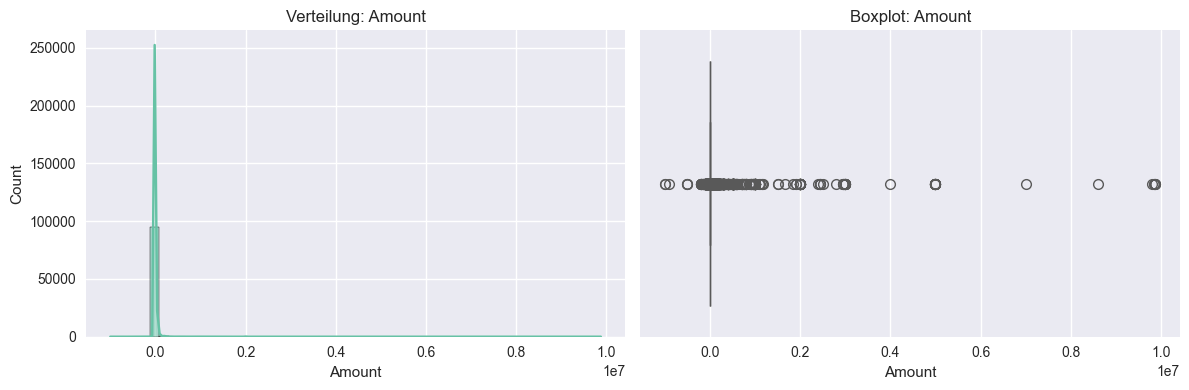

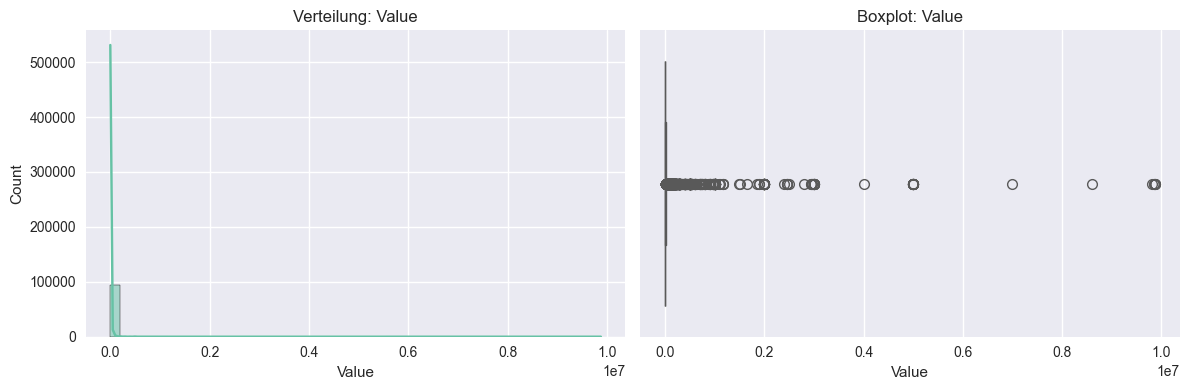

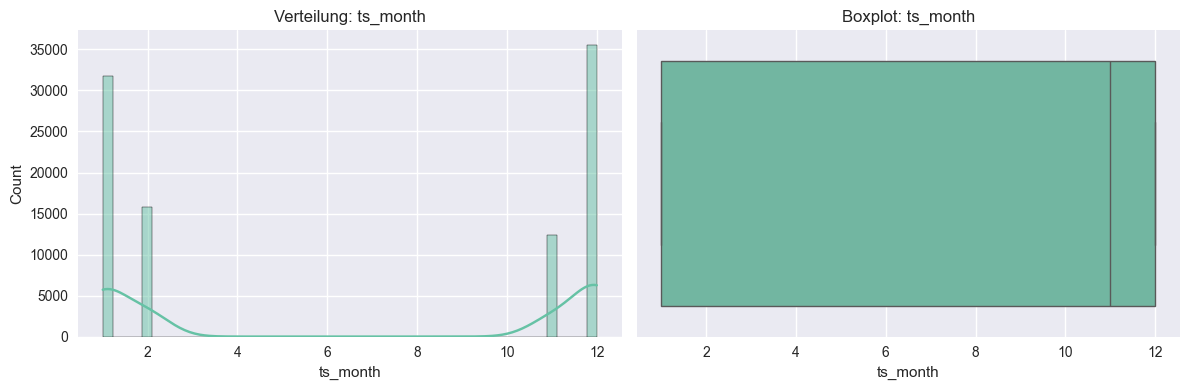

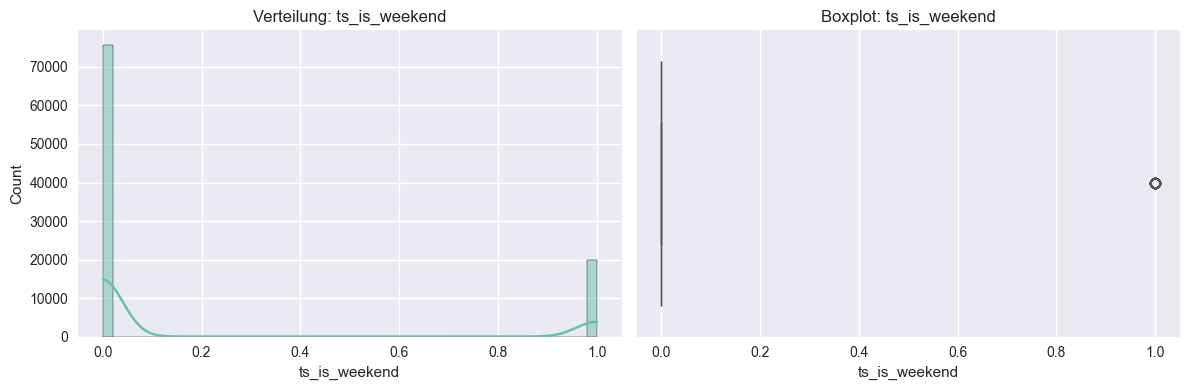

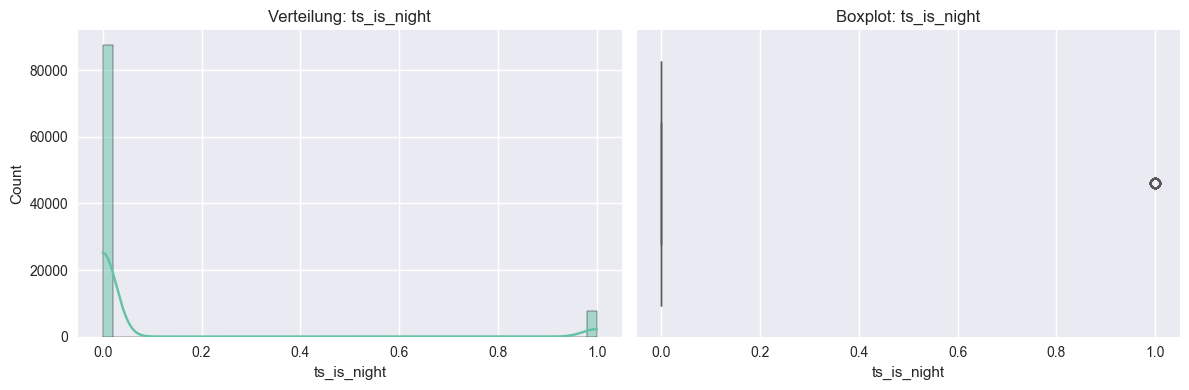

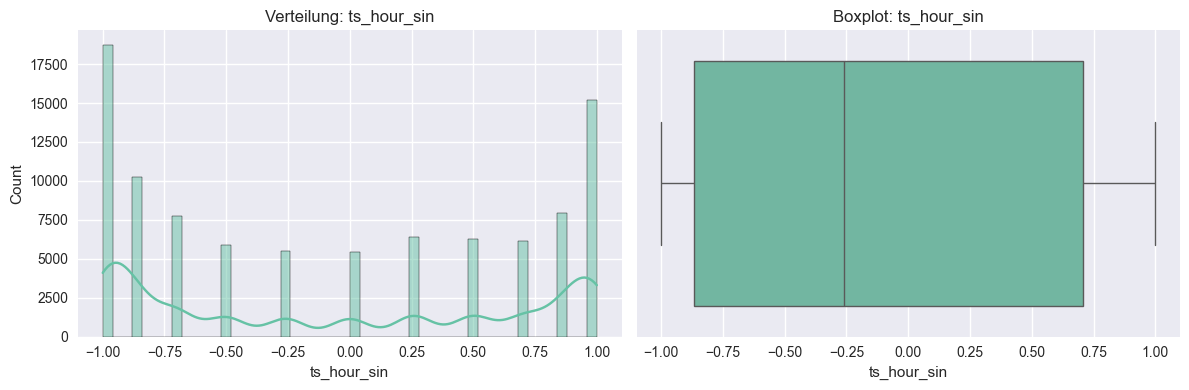

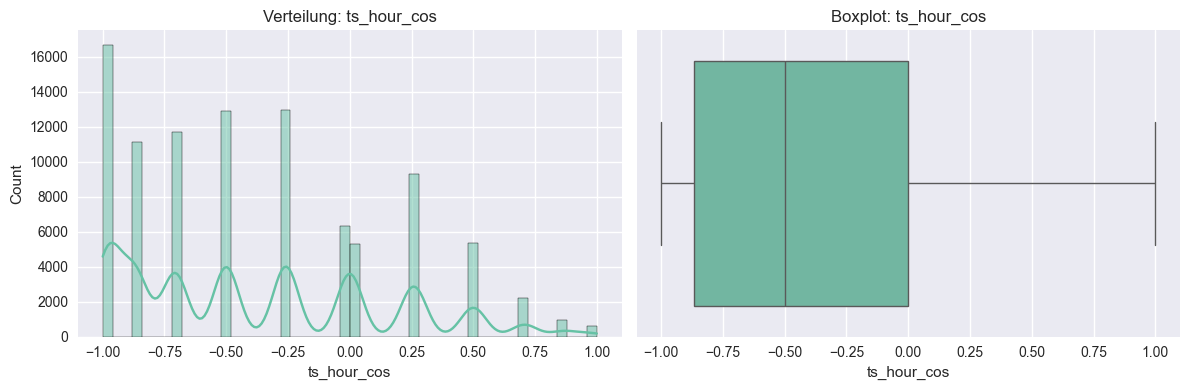

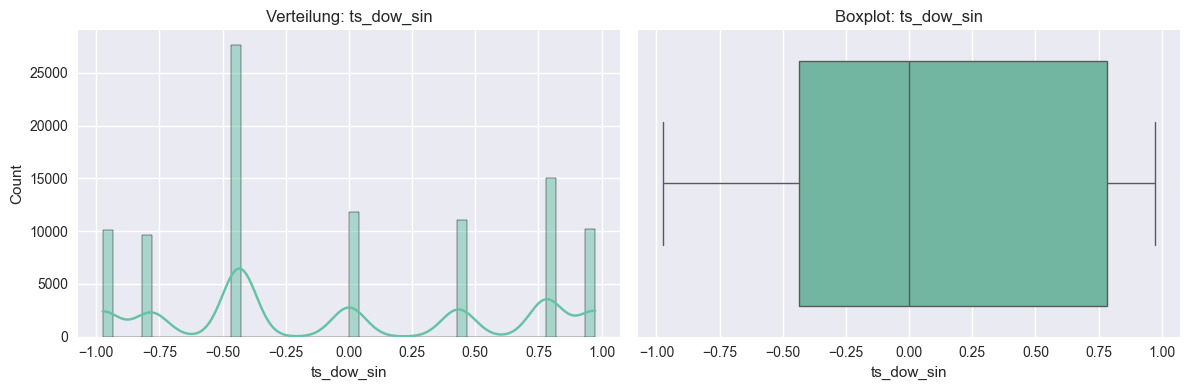

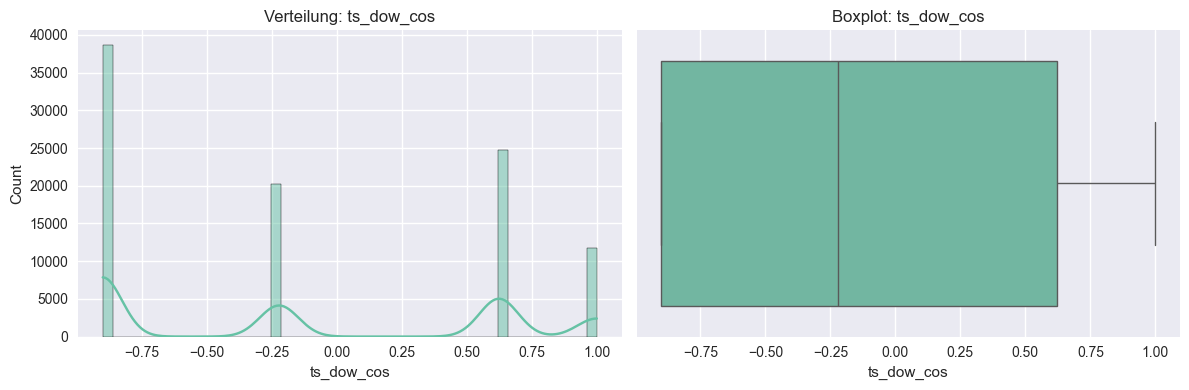

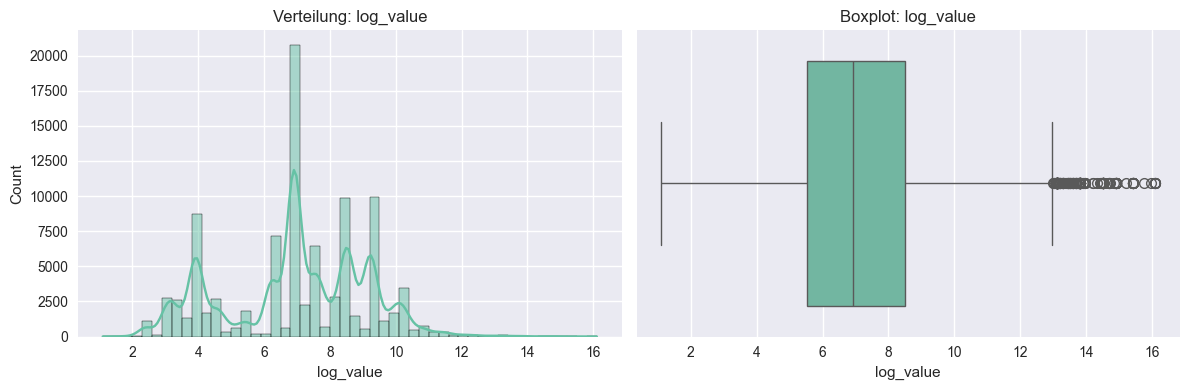

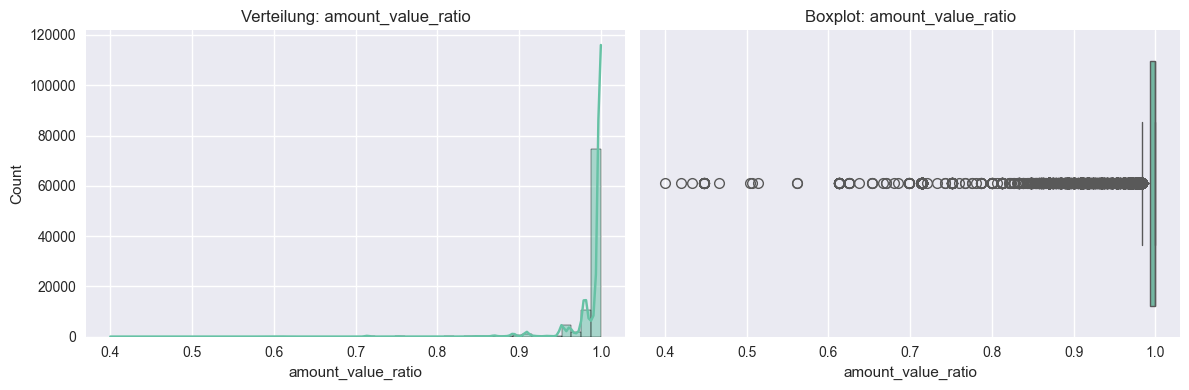

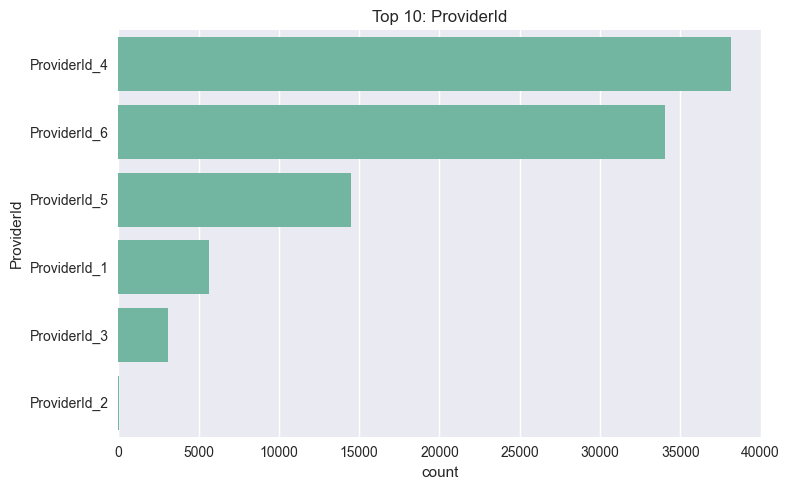

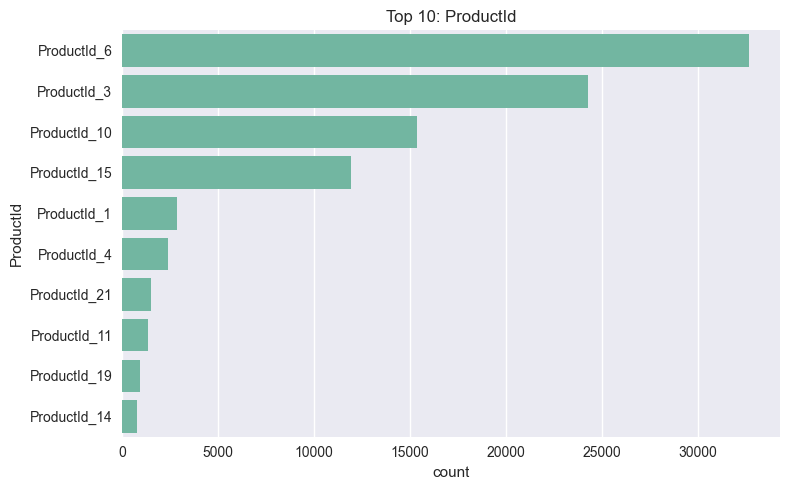

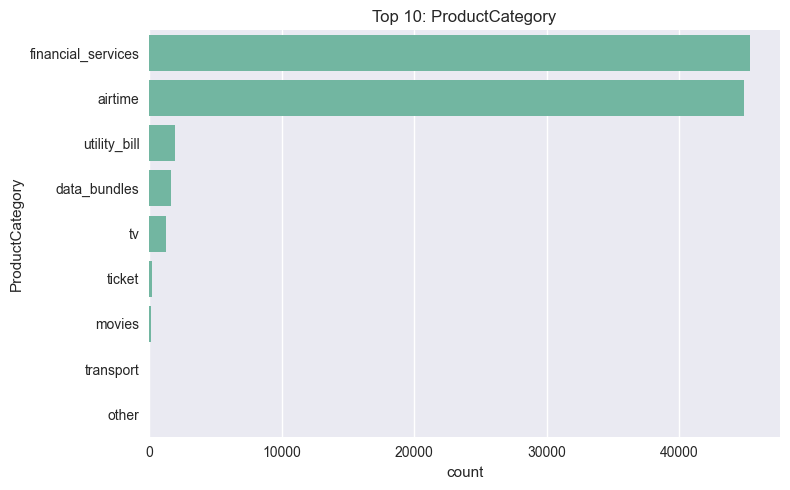

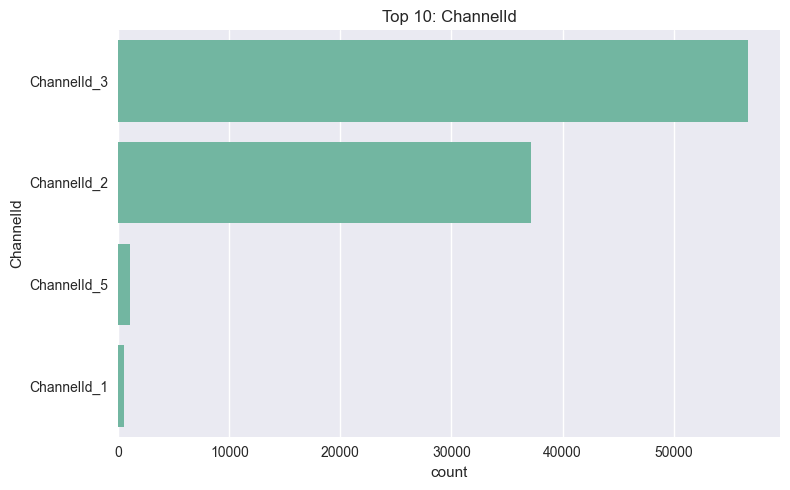

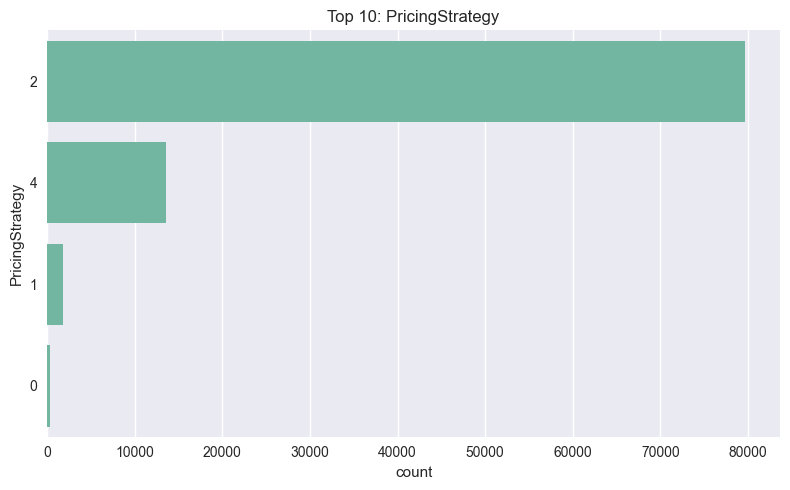

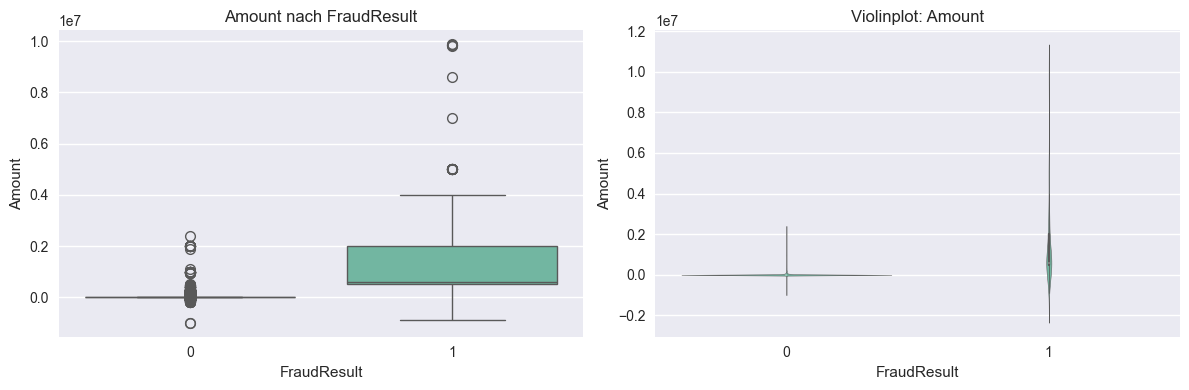

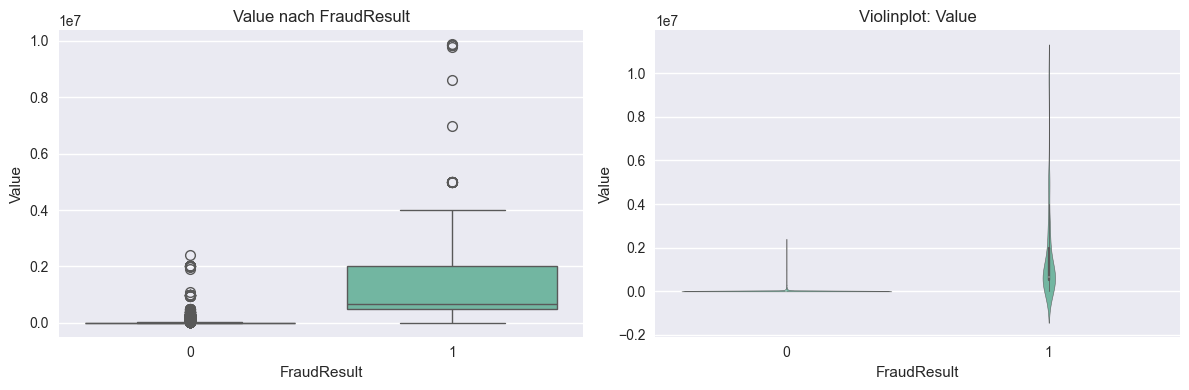

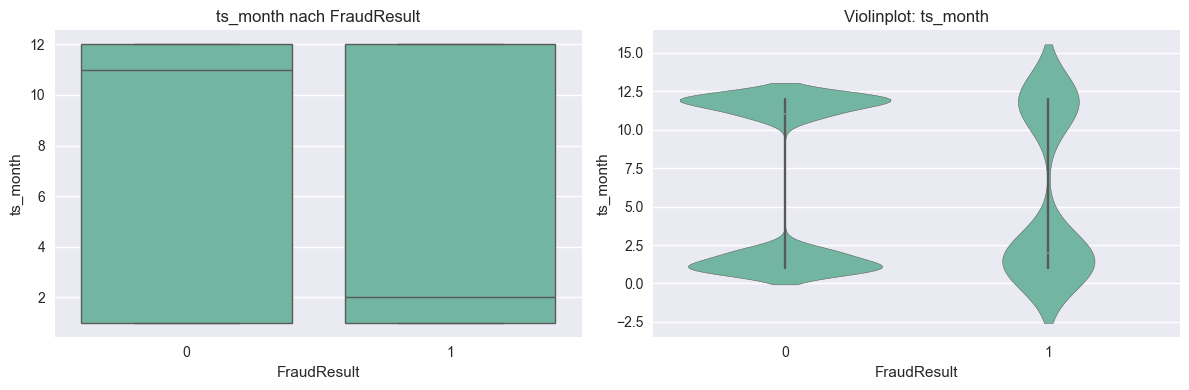

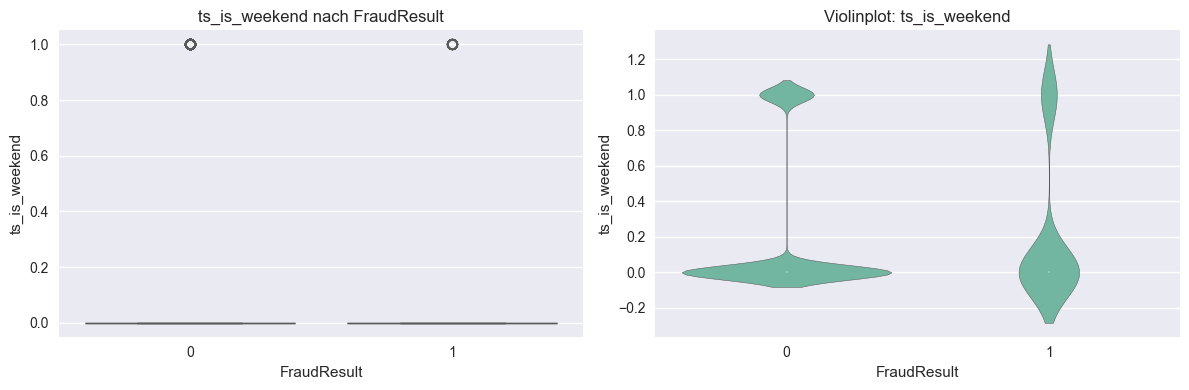

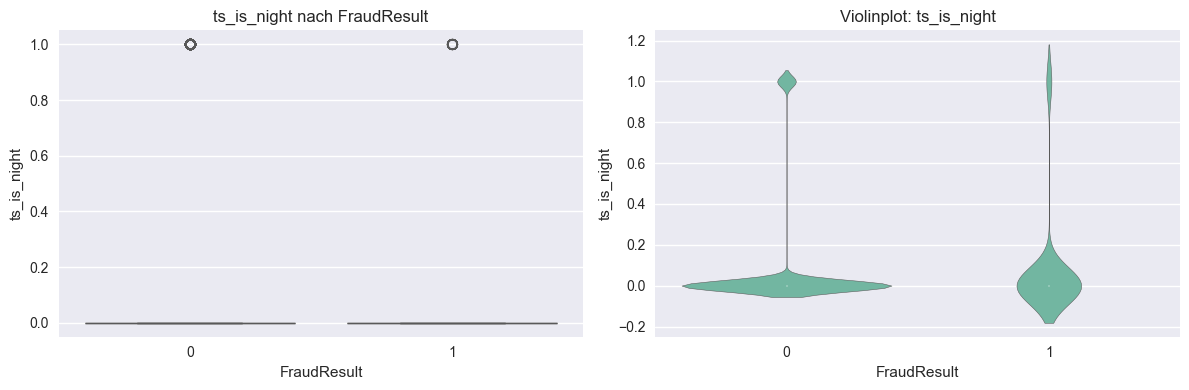

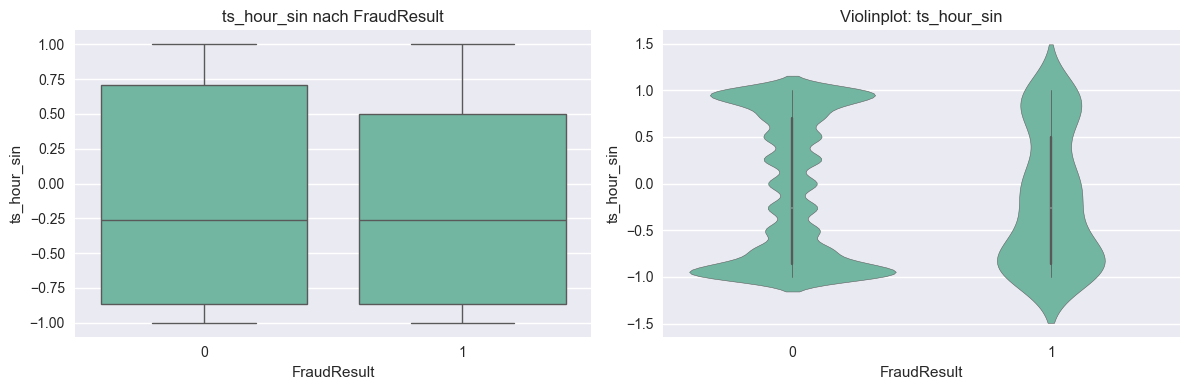

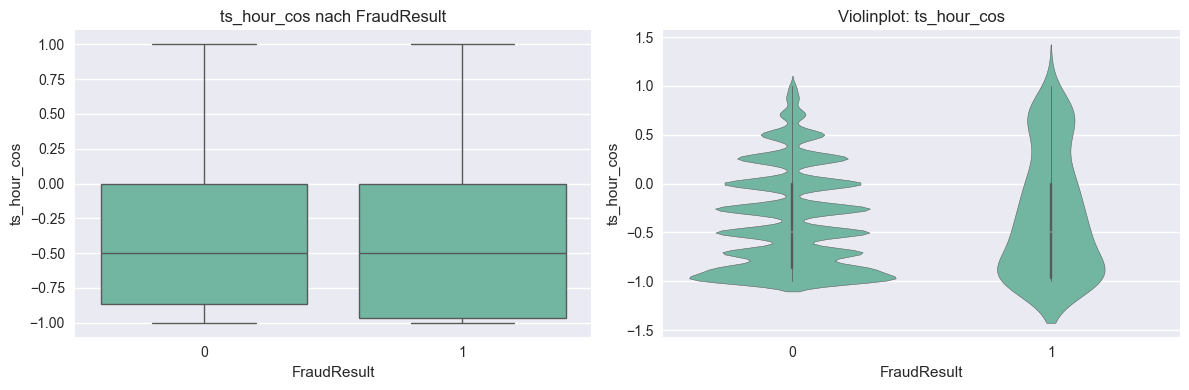

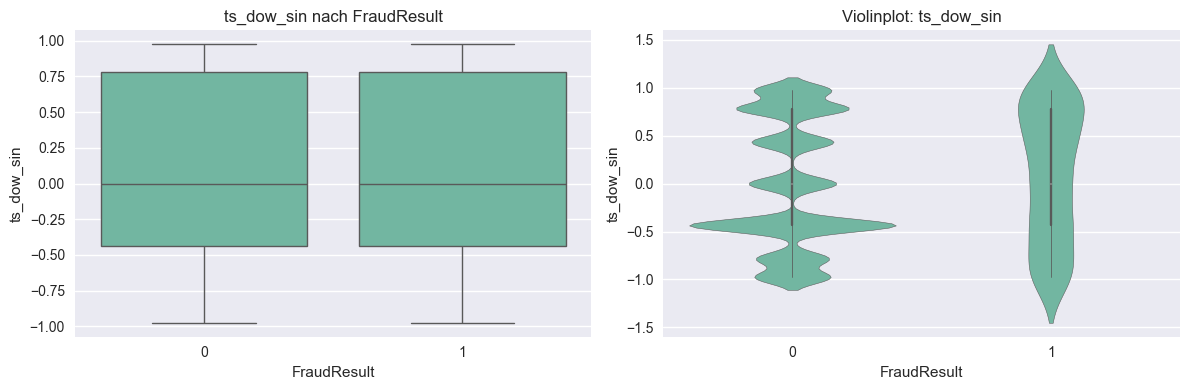

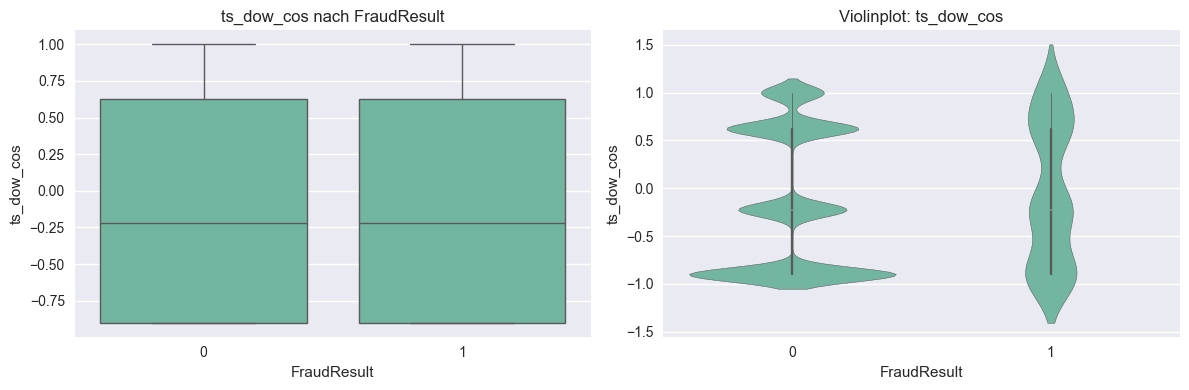

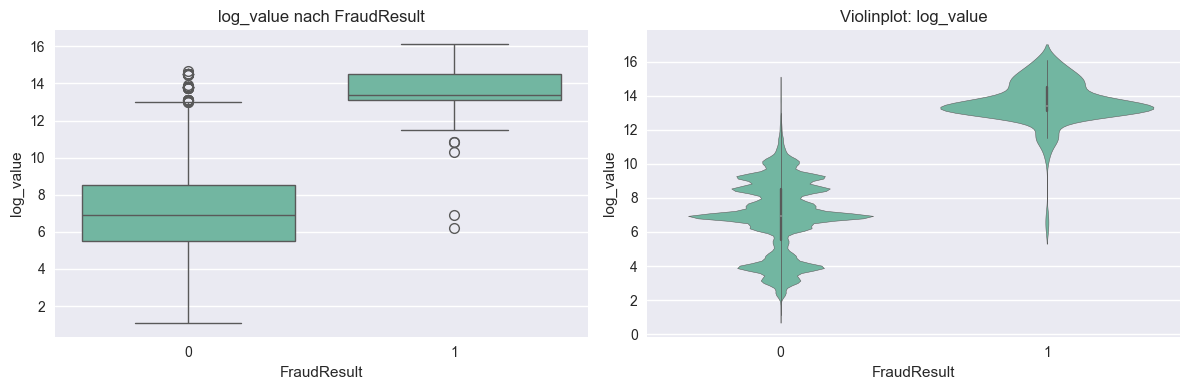

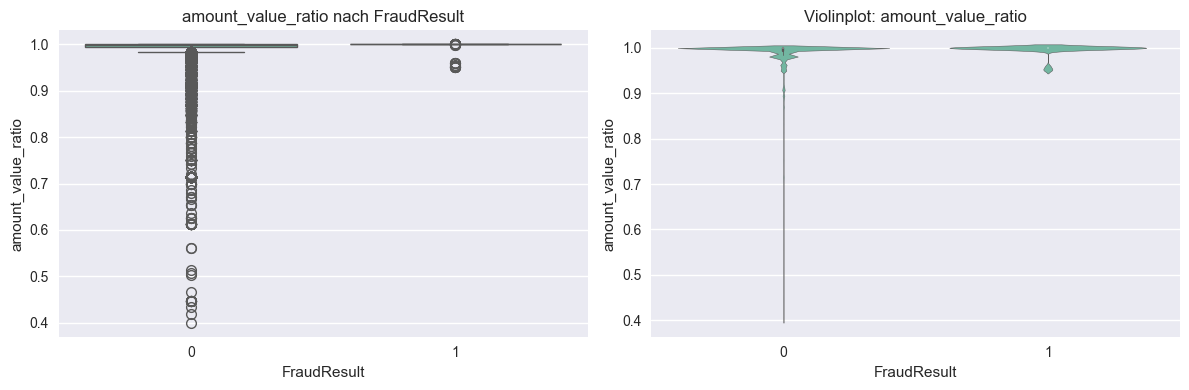

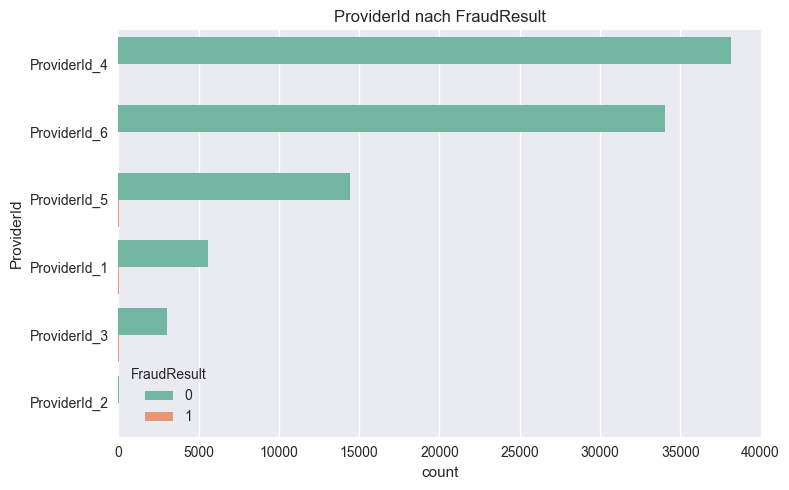

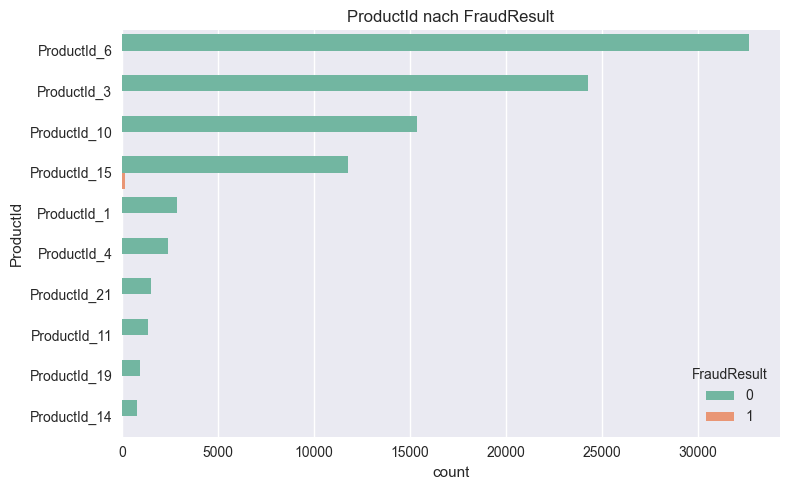

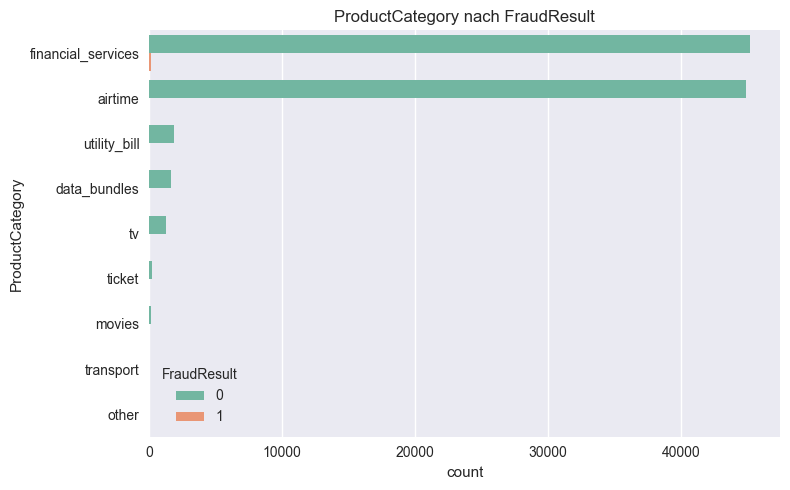

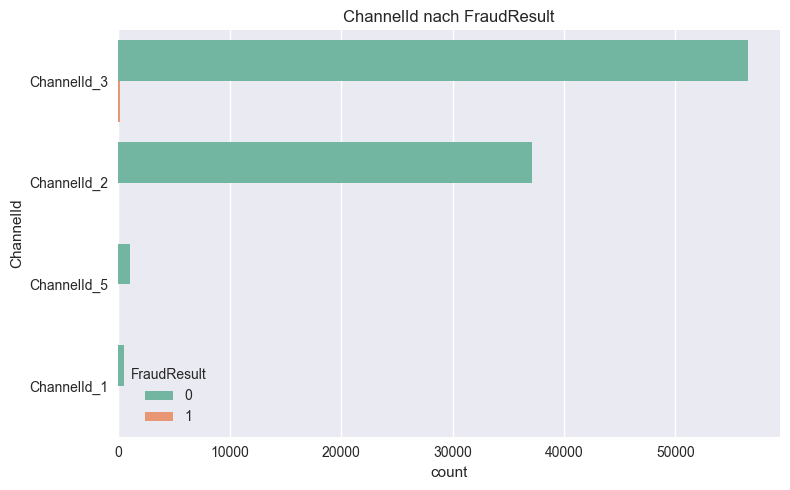

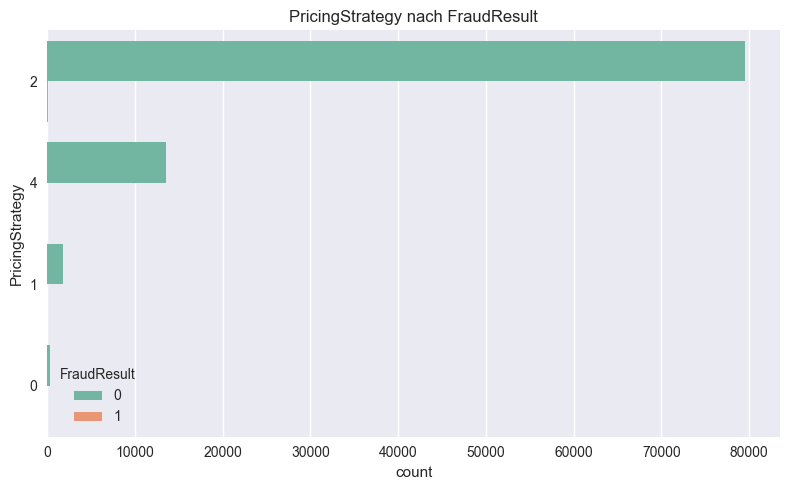

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')
%matplotlib inline

# Extraktion der Merkmalslisten
TARGET = "FraudResult"

# PricingStrategy ist kategorial (wurde im Preprocessing zu String konvertiert)
# Obwohl es in der CSV als Zahl gespeichert ist, muss es als Kategorie behandelt werden
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'PricingStrategy' in df.columns and 'PricingStrategy' not in categorical_cols:
    categorical_cols.append('PricingStrategy')

# Numerische Features extrahieren, aber TARGET und PricingStrategy explizit ausschließen
numeric_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c != TARGET and c != 'PricingStrategy'
]

print(f"Numerische Merkmale ({len(numeric_cols)}): {numeric_cols}")
print(f"Kategoriale Merkmale ({len(categorical_cols)}): {categorical_cols}\n")

# Univariate Analyse: numerische Merkmale
for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col], bins=50, kde=True, ax=ax[0])
    ax[0].set_title(f"Verteilung: {col}")
    sns.boxplot(x=df[col], ax=ax[1])
    ax[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

# ===== Univariate Analyse: kategoriale Merkmale =====
# Balkendiagramm zeigt die Häufigkeit der Top-10-Kategorien
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=col, data=df, order=df[col].value_counts().head(10).index)
    plt.title(f"Top 10: {col}")
    plt.tight_layout()
    plt.show()

# ===== Bivariate Analyse: numerische Merkmale vs. Zielvariable =====
# Vergleich der Verteilungen zwischen Betrug (1) und Nicht-Betrug (0)
for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(x=TARGET, y=col, data=df, ax=ax[0])
    ax[0].set_title(f"{col} nach {TARGET}")
    sns.violinplot(x=TARGET, y=col, data=df, ax=ax[1])
    ax[1].set_title(f"Violinplot: {col}")
    plt.tight_layout()
    plt.show()

# ===== Bivariate Analyse: kategoriale Merkmale vs. Zielvariable =====
# Zeigt, wie sich Betrug über verschiedene Kategorien verteilt
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=col, hue=TARGET, data=df, order=df[col].value_counts().head(10).index)
    plt.title(f"{col} nach {TARGET}")
    plt.legend(title=TARGET)
    plt.tight_layout()
    plt.show()


### Korrelationsanalyse numerischer Merkmale

In diesem Abschnitt wird die Korrelation zwischen den numerischen Merkmalen sowie der Zielvariable (`FraudResult`) untersucht. Ziel ist es, **lineare Zusammenhänge**, **redundante Features** und potenzielle **Multikollinearität** zu identifizieren.

Die Korrelationsmatrix hilft dabei zu erkennen, welche Variablen stark miteinander zusammenhängen und welche Merkmale einen direkten linearen Zusammenhang mit der Zielvariable aufweisen. Diese Erkenntnisse sind besonders relevant für die Feature Selection sowie für Modelle, die empfindlich auf korrelierte Eingangsvariablen reagieren (z. B. **lineare Modelle**).


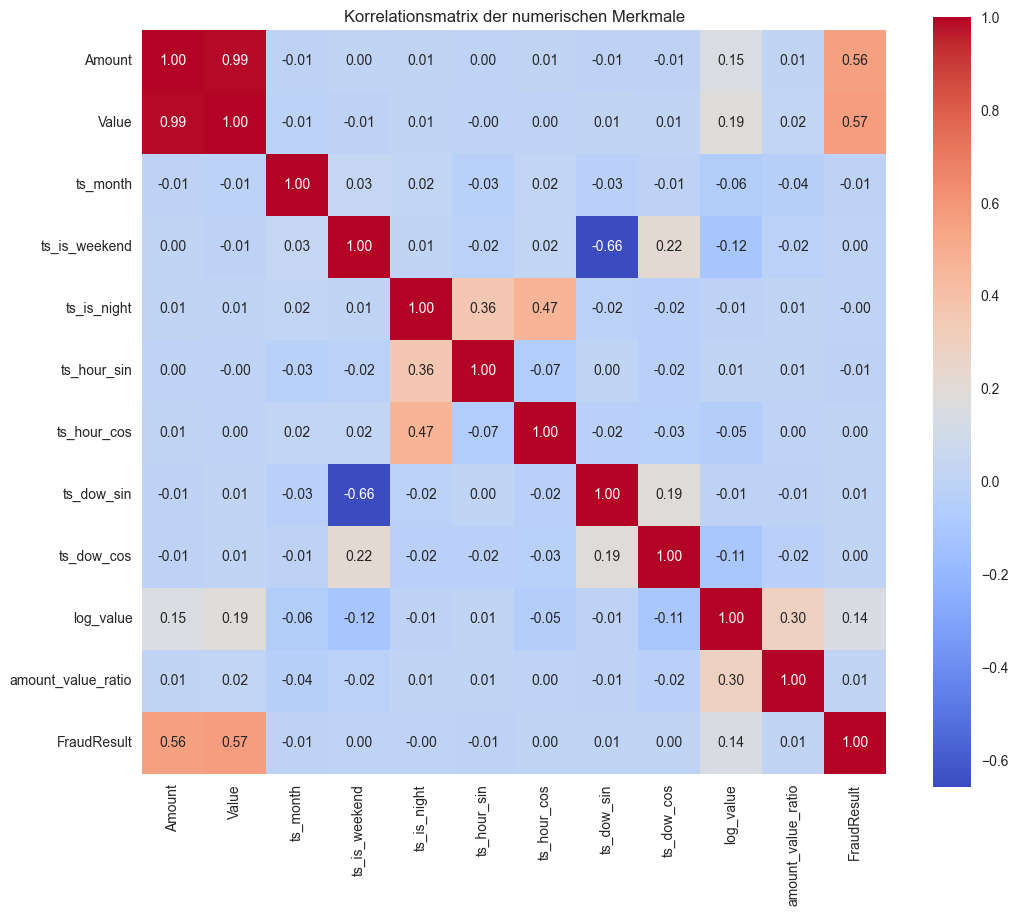

Stark korrelierte Feature-Paare (> 0.95):
   • Amount ↔ Value: 0.990

💡 EMPFEHLUNG: Redundante Features

Amount und Value sind zu 99% identisch → EINES muss entfernt werden!

✅ VERWENDE: log_value
❌ ENTFERNE: Amount, Value

GRÜNDE:
   1. log_value hat normalere Verteilung (besser für ML-Modelle)
   2. Reduziert Einfluss von Ausreißern (sehr hohe Beträge)
   3. Amount/Value sind redundant → keine zusätzliche Information
   4. Weniger Features → schnelleres Training, weniger Overfitting

📊 VERTEILUNGS-VERGLEICH: Amount vs. log_value

Schiefe (Skewness):
   Amount:       51.04  ← Extrem rechtsschief!
   log_value:    -0.20  ← Fast normal verteilt

   → log_value ist 252x symmetrischer!

💡 FAZIT:
   → Für Modellierung: Verwende nur log_value
   → Amount und Value können gelöscht werden


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns 

# korrelation matrix for numeric features
plt.figure(figsize=(12, 10))    
corr = df[numeric_cols + [TARGET]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Korrelationsmatrix der numerischen Merkmale")    
plt.show()

# Welche Features sind redundant?
corr_matrix = df[numeric_cols + ['FraudResult']].corr()

# Paare mit Korrelation > 0.95 finden
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("Stark korrelierte Feature-Paare (> 0.95):")
for feat1, feat2, corr in high_corr:
    print(f"   • {feat1} ↔ {feat2}: {corr:.3f}")

if len(high_corr) > 0:
    print("\n" + "="*70)
    print("💡 EMPFEHLUNG: Redundante Features")
    print("="*70)
    print("\nAmount und Value sind zu 99% identisch → EINES muss entfernt werden!")
    print("\n✅ VERWENDE: log_value")
    print("❌ ENTFERNE: Amount, Value")
    print("\nGRÜNDE:")
    print("   1. log_value hat normalere Verteilung (besser für ML-Modelle)")
    print("   2. Reduziert Einfluss von Ausreißern (sehr hohe Beträge)")
    print("   3. Amount/Value sind redundant → keine zusätzliche Information")
    print("   4. Weniger Features → schnelleres Training, weniger Overfitting")
    
    # Verteilungs-Vergleich
    print("\n" + "="*70)
    print("📊 VERTEILUNGS-VERGLEICH: Amount vs. log_value")
    print("="*70)
    
    from scipy.stats import skew
    
    amount_skew = skew(df['Amount'])
    log_value_skew = skew(df['log_value'])
    
    print(f"\nSchiefe (Skewness):")
    print(f"   Amount:    {amount_skew:>8.2f}  ← Extrem rechtsschief!")
    print(f"   log_value: {log_value_skew:>8.2f}  ← Fast normal verteilt")
    print(f"\n   → log_value ist {abs(amount_skew / log_value_skew):.0f}x symmetrischer!")
    
    print("\n💡 FAZIT:")
    print("   → Für Modellierung: Verwende nur log_value")
    print("   → Amount und Value können gelöscht werden")
else:
    print("\n✅ Keine stark korrelierten Feature-Paare gefunden!")





## Kategoriale Features Analyse:

In [57]:
from scipy.stats import chi2_contingency
import numpy as np

# ===== KATEGORIALE FEATURES vs. FRAUDRESULT =====
print("="*70)
print("📊 KATEGORIALE FEATURES vs. FraudResult")
print("="*70)

categorical_features = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']

results = []

for feature in categorical_features:
    # Kontingenztabelle erstellen
    contingency_table = pd.crosstab(df[feature], df['FraudResult'])
    
    # Chi-Square Test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Cramér's V berechnen (Stärke des Zusammenhangs)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    
    results.append({
        'Feature': feature,
        'Chi-Square': chi2,
        'p-value': p_value,
        "Cramér's V": cramers_v,
        'Signifikant': '✅ JA' if p_value < 0.05 else '❌ NEIN'
    })

# Ergebnisse als DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Cramér's V", ascending=False)

print("\nZusammenhang kategoriale Features mit FraudResult:")
print("-" * 70)
display(results_df)

print("\n" + "="*70)
print("💡 INTERPRETATION:")
print("="*70)
print("Cramér's V Werte:")
print("   0.0 - 0.1: Sehr schwacher Zusammenhang")
print("   0.1 - 0.3: Schwacher Zusammenhang")
print("   0.3 - 0.5: Mittlerer Zusammenhang")
print("   > 0.5: Starker Zusammenhang")
print("\np-value < 0.05: Statistisch signifikanter Zusammenhang")

print("\n" + "="*70)
print("📊 FAZIT:")
print("="*70)

for idx, row in results_df.iterrows():
    feature = row['Feature']
    cramers = row["Cramér's V"]
    sig = row['Signifikant']
    
    if cramers > 0.3:
        strength = "🟢 STARK"
    elif cramers > 0.1:
        strength = "🟡 MITTEL"
    else:
        strength = "🔴 SCHWACH"
    
    print(f"   {feature:20s}: {strength} (Cramér's V = {cramers:.3f}, {sig})")

print("\n✅ Alle kategoriale Features zeigen signifikante Zusammenhänge!")
print("   → BESTÄTIGT unsere Hypothesen-Tests!")
print("   → ProductId, PricingStrategy, ProductCategory besonders wichtig")

📊 KATEGORIALE FEATURES vs. FraudResult

Zusammenhang kategoriale Features mit FraudResult:
----------------------------------------------------------------------


,Feature,Chi-Square,p-value,Cramér's V,Signifikant
4,PricingStrategy,1612.601048,0.000000e+00,0.129976,✅ JA
1,ProductId,1259.853363,7.351799e-253,0.114884,✅ JA
0,ProviderId,894.199473,4.791573e-191,0.096787,✅ JA
2,ProductCategory,209.960807,5.072618e-41,0.046899,✅ JA
3,ChannelId,117.405441,2.793635e-25,0.035071,✅ JA



💡 INTERPRETATION:
Cramér's V Werte:
   0.0 - 0.1: Sehr schwacher Zusammenhang
   0.1 - 0.3: Schwacher Zusammenhang
   0.3 - 0.5: Mittlerer Zusammenhang
   > 0.5: Starker Zusammenhang

p-value < 0.05: Statistisch signifikanter Zusammenhang

📊 FAZIT:
   PricingStrategy     : 🟡 MITTEL (Cramér's V = 0.130, ✅ JA)
   ProductId           : 🟡 MITTEL (Cramér's V = 0.115, ✅ JA)
   ProviderId          : 🔴 SCHWACH (Cramér's V = 0.097, ✅ JA)
   ProductCategory     : 🔴 SCHWACH (Cramér's V = 0.047, ✅ JA)
   ChannelId           : 🔴 SCHWACH (Cramér's V = 0.035, ✅ JA)

✅ Alle kategoriale Features zeigen signifikante Zusammenhänge!
   → BESTÄTIGT unsere Hypothesen-Tests!
   → ProductId, PricingStrategy, ProductCategory besonders wichtig


# Analyse der Fraud-Detection-Daten

## Univariate Analyse – Numerische Features (Histogramm + Boxplot)

**Amount & Value:**  
- Wir sehen eine extreme Rechtsschiefe: Die meisten Transaktionen liegen im Bereich von 0 bis 5.000, aber es gibt Ausreißer bis 50.000.  
- Warum wichtig? Sehr hohe Beträge könnten verdächtig sein.  
- Problem: Modelle haben Schwierigkeiten mit dieser Schiefe.

**log_value:**  
- Nach der Log-Transformation zeigt sich eine deutlich normalere Verteilung ohne extreme Schiefe.  
- Warum? Log-Transformation macht die Daten für ML-Modelle besser verarbeitbar.  
- Nutzen: Dieses Feature sollte anstelle von "Value" verwendet werden.

**amount_value_ratio:**  
- Fast alle Werte liegen bei 1.0 (Amount = Value), nur wenige Ausnahmen gibt es.  
- Warum wichtig? Wenn Amount ≠ Value, könnte das ein Hinweis auf Betrug (Manipulation) sein.  
- Nutzen: Sehr guter Indikator für Anomalien.

**ts_month:**  
- Die Daten stammen aus 3-4 Monaten und sind relativ gleichmäßig verteilt.  
- Warum wichtig? Mögliche saisonale Muster beim Betrug können erkannt werden.  
- Nutzen: Zeigt, ob Betrüger zu bestimmten Zeiten aktiver sind.

**ts_is_weekend (0 oder 1):**  
- Etwa 70 % der Transaktionen sind Werktagstransaktionen, 30 % am Wochenende.  
- Warum wichtig? Eventuell mehr Betrug am Wochenende aufgrund geringerer Kontrolle.  
- Nutzen: Erkennt zeitliche Verhaltensmuster.

**ts_is_night (0 oder 1):**  
- Nur ca. 8 % der Transaktionen erfolgen nachts, also sehr selten.  
- Warum wichtig? Nachts könnten Transaktionen verdächtiger sein.  
- Nutzen: Starker Indikator – insbesondere nachts UND hohe Beträge sollten geprüft werden.

**ts_hour_sin/cos & ts_dow_sin/cos:**  
- Die Werte schwanken wellenförmig zwischen -1 und +1.  
- Warum so kodiert? Damit Modelle zyklische Daten (z. B. Stunde 23 und 0) richtig interpretieren können.  
- Nutzen: Ermöglicht Modellen bessere Erfassung von Tages- und Wochenzeiten.

---

## Univariate Analyse – Kategoriale Features (Balkendiagramme)

**ProviderId:**  
- ProviderId_4 macht etwa 40 % der Transaktionen aus, die anderen Provider sind deutlich kleiner vertreten.  
- Warum wichtig? Wenn bei Provider_4 mehr Betrug vorkommt, sollte der Fokus darauf liegen.  
- Nutzen: Identifikation von Risikoprovodern.

**ProductId:**  
- Es gibt 23 verschiedene Produkte, aber nur wenige dominieren die Transaktionen.  
- Warum wichtig? Manche Produkte könnten anfälliger für Betrug sein.  
- Nutzen: Erkennung von risikobehafteten Produktgruppen.

**ProductCategory:**  
- 90 % der Daten gehören zur Kategorie "financial_services", alle anderen sind sehr selten.  
- Warum wichtig? Es zeigt den Schwerpunkt des Datensatzes.  
- Nutzen: Konzentration auf Finanzdienstleistungen.

**ChannelId:**  
- Vier Kanäle existieren, einer dominiert klar.  
- Warum wichtig? Manche Kanäle sind möglicherweise anfälliger für Betrug (z. B. Web vs. Mobile).  
- Nutzen: Erkenntnis über die relevanten Kanäle.

**PricingStrategy:**  
- Vier Strategien sind relativ gleichmäßig verteilt.  
- Warum wichtig? Bestimmte Preismodelle könnten betrugsanfälliger sein.  
- Nutzen: Potentielle Geschäfts-Logik-Betrugsindikatoren.

---

## Bivariate Analyse – Numerisch vs. FraudResult (Boxplot + Violinplot)

**Amount/Value bei Betrug vs. Normal:**  
- Vergleich zeigt, ob betrügerische Transaktionen tendenziell teurer oder günstiger sind.  
- Nutzen: Wenn Betrüger eher hohe Beträge bevorzugen, kann dies als Warnsignal genutzt werden.

**ts_is_night bei Betrug:**  
- Erwartung: Mehr Betrug nachts?  
- Nutzen: Erkennt zeitliche Muster beim Betrug.

**amount_value_ratio bei Betrug:**  
- Haben Betrüger häufiger Abweichungen vom Verhältnis 1?  
- Nutzen: Ein perfekter Indikator für Betrug, wenn ja.

---

## Bivariate Analyse – Kategorial vs. FraudResult (Countplot mit Farben)

**ProviderId:**  
- Hat Provider_4 mehr Betrug als andere Provider?  
- Nutzen: Zeigt, welche Provider risikoreicher sind.

**ProductCategory:**  
- Ist "financial_services" besonders betrugsanfällig?  
- Nutzen: Erkennt Risiko-Kategorien.

**ChannelId:**  
- Welcher Kanal weist mehr Betrug auf? (z. B. Web, Mobile, Filiale)  
- Nutzen: Zeigt, wo Sicherheitsmaßnahmen verbessert werden müssen.

---

## Warum haben wir diese Methoden verwendet?

- **Histogramm:** Zeigt Verteilung der Daten, Schiefe und Ausreißer.  
- **Boxplot:** Verdeutlicht Quartile, Ausreißer und zentrale Tendenz.  
- **Countplot:** Darstellung der Häufigkeit von Kategorien.  
- **Violinplot:** Visualisiert Verteilungsform, Unterschiede bei Betrugs- und Normalfällen.  
- **Bivariate Analyse mit Farben:** Hebt Unterschiede zwischen betrügerischen und normalen Transaktionen hervor.

---

## Wie hilft uns diese Analyse weiter?

1. **Feature Selection:**  
   - Features mit ähnlichem Verhalten bei Betrug und Normal sind weniger relevant.  
   - Features mit klaren Unterschieden sind wichtig für das Modell.

2. **Preprocessing-Entscheidungen:**  
   - Nutzung der log_value, um Schiefe zu beheben.  
   - Möglicher Einsatz von StandardScaler bei numerischen Features.  
   - Umgang mit kategorialen Variablen und deren Imbalance (z. B. OneHotEncoding).

3. **Hypothesen über Betrug:**  
   - Betrüger sind evtl. nachts aktiver.  
   - Bestimmte Provider oder Produkte sind anfälliger.  
   - Hohe Transaktionsbeträge sind verdächtig.

4. **Modellerwartungen:**  
   - Starke Überlappung von Betrugs- und Nicht-Betrugsfällen erschwert Klassifikation.  
   - Klare Unterschiedlichkeit erleichtert Modellgüte.  
   - Analyse zeigt, welche Features wahrscheinlich von ML-Modellen genutzt werden.

---

Diese Erkenntnisse bilden eine solide Grundlage, um zukünftige Machine-Learning-Modelle für Fraud Detection gezielt zu verbessern.

## Hypothese(ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy')

In [47]:
import pandas as pd

df = pd.read_csv("../data/processed/training_preprocessed.csv")

# Feature analysieren
kategoriale_features = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']
for feature in kategoriale_features:
    print(f"\n{'='*80}")
    print(f"🔎 {feature}")
    print('='*80)
    
    
    # Betrugsrate pro Kategorie berechnen
    fraud_analysis = df.groupby(feature)['FraudResult'].agg(['sum', 'count', 'mean'])
    fraud_analysis['fraud_rate_%'] = fraud_analysis['mean'] * 100
    fraud_analysis['risk_factor'] = fraud_analysis['mean'] / df['FraudResult'].mean()
    fraud_analysis = fraud_analysis.sort_values('fraud_rate_%', ascending=False)
    
    # Spalten umbenennen
    fraud_analysis.columns = ['Anzahl Betrüge', 'Gesamt', 'Rate', 'Betrugsrate %', 'Risiko-Faktor']
    
    print(fraud_analysis)
    
    # Top 3 riskante Kategorien hervorheben
    print(f"\n⚠️  Top 3 riskanteste Kategorien:")
    for idx in fraud_analysis.index[:3]:
        rate = fraud_analysis.loc[idx, 'Betrugsrate %']
        faktor = fraud_analysis.loc[idx, 'Risiko-Faktor']
        count = fraud_analysis.loc[idx, 'Anzahl Betrüge']
        print(f"   • {idx}: {rate:.3f}% ({faktor:.1f}x Risiko, {int(count)} Betrüge)")

print(fraud_analysis)


🔎 ProviderId
              Anzahl Betrüge  Gesamt      Rate  Betrugsrate %  Risiko-Faktor
ProviderId                                                                  
ProviderId_3              64    3070  0.020847       2.084691      10.310685
ProviderId_1              57    5632  0.010121       1.012074       5.005623
ProviderId_5              64   14498  0.004414       0.441440       2.183322
ProviderId_4               5   38180  0.000131       0.013096       0.064771
ProviderId_6               3   34058  0.000088       0.008809       0.043566
ProviderId_2               0      18  0.000000       0.000000       0.000000

⚠️  Top 3 riskanteste Kategorien:
   • ProviderId_3: 2.085% (10.3x Risiko, 64 Betrüge)
   • ProviderId_1: 1.012% (5.0x Risiko, 57 Betrüge)
   • ProviderId_5: 0.441% (2.2x Risiko, 64 Betrüge)

🔎 ProductId
              Anzahl Betrüge  Gesamt      Rate  Betrugsrate %  Risiko-Faktor
ProductId                                                                   
ProductId_9

## Hypothese: Sind Betrüger nachts aktiver?

In [48]:
import pandas as pd

df = pd.read_csv("../data/processed/training_preprocessed.csv")

# Betrugsrate nach Tageszeit berechnen
night_fraud = df.groupby('ts_is_night')['FraudResult'].agg(['sum', 'count', 'mean'])

# Tag vs. Nacht vergleichen
tag_rate = night_fraud.loc[0, 'mean'] * 100      # ts_is_night = 0
nacht_rate = night_fraud.loc[1, 'mean'] * 100    # ts_is_night = 1

print(f"Tag:   {tag_rate:.3f}% Betrug")
print(f"Nacht: {nacht_rate:.3f}% Betrug")
print(f"Faktor: {nacht_rate / tag_rate:.2f}x")

Tag:   0.204% Betrug
Nacht: 0.179% Betrug
Faktor: 0.88x


Fazit: Tageszeit ist kein starker Indikator. Betrug passiert zu allen Zeiten ähnlich häufig. bringt nichts bei der weitere Analysen

## HYPOTHESE: Wochenende

In [49]:
# ===== HYPOTHESE: Gibt es mehr Betrug am Wochenende? =====
print("="*70)
print("📅 Gibt es mehr Betrug am Wochenende?")
print("="*70)

# Betrugsrate nach Wochenende/Werktag
weekend_fraud = df.groupby('ts_is_weekend')['FraudResult'].agg(['sum', 'count', 'mean'])
weekend_fraud['fraud_rate_%'] = weekend_fraud['mean'] * 100
weekend_fraud.index = ['Werktag (0)', 'Wochenende (1)']

print("\nBetrugsrate nach Wochentag:")
print(weekend_fraud)

# Vergleich
werktag_rate = weekend_fraud.loc['Werktag (0)', 'fraud_rate_%']
wochenende_rate = weekend_fraud.loc['Wochenende (1)', 'fraud_rate_%']
faktor = wochenende_rate / werktag_rate if werktag_rate > 0 else 0

print(f"\n📊 ERGEBNIS:")
print(f"   Werktag:    {werktag_rate:.3f}% Betrug")
print(f"   Wochenende: {wochenende_rate:.3f}% Betrug")
print(f"   → Am Wochenende ist Betrug {faktor:.2f}x häufiger!")

if faktor > 1.5:
    print(f"\n✅ FAZIT: JA! Mehr Betrug am Wochenende!")
elif faktor > 1.05:
    print(f"\n⚠️  FAZIT: Leicht erhöht am Wochenende")
else:
    print(f"\n❌ FAZIT: NEIN, Wochenende spielt keine Rolle")

📅 Gibt es mehr Betrug am Wochenende?

Betrugsrate nach Wochentag:
                sum  count      mean  fraud_rate_%
Werktag (0)     153  75701  0.002021      0.202111
Wochenende (1)   40  19755  0.002025      0.202480

📊 ERGEBNIS:
   Werktag:    0.202% Betrug
   Wochenende: 0.202% Betrug
   → Am Wochenende ist Betrug 1.00x häufiger!

❌ FAZIT: NEIN, Wochenende spielt keine Rolle


##  HYPOTHESE: Saisonale Muster (Monat)

In [50]:
# ===== HYPOTHESE: Gibt es saisonale Muster nach Monat? =====
print("="*70)
print("📆 Gibt es saisonale Muster nach Monat?")
print("="*70)

# Betrugsrate pro Monat
month_fraud = df.groupby('ts_month')['FraudResult'].agg(['sum', 'count', 'mean'])
month_fraud['fraud_rate_%'] = month_fraud['mean'] * 100
month_fraud['risk_factor'] = month_fraud['mean'] / df['FraudResult'].mean()
month_fraud = month_fraud.sort_values('fraud_rate_%', ascending=False)

print("\nBetrugsrate pro Monat (sortiert nach Risiko):")
print(month_fraud)

avg_rate = df['FraudResult'].mean() * 100
print(f"\n📊 Durchschnittliche Betrugsrate: {avg_rate:.3f}%")

# Riskanteste Monate (> 1.5x Durchschnitt)
riskante_monate = month_fraud[month_fraud['fraud_rate_%'] > avg_rate * 1.5]

if len(riskante_monate) > 0:
    print(f"\n✅ FAZIT: JA! Es gibt riskantere Monate:")
    for monat in riskante_monate.index:
        rate = riskante_monate.loc[monat, 'fraud_rate_%']
        faktor = riskante_monate.loc[monat, 'risk_factor']
        count = riskante_monate.loc[monat, 'sum']
        print(f"   • Monat {monat}: {rate:.3f}% ({faktor:.2f}x Risiko, {int(count)} Betrüge)")
else:
    print(f"\n❌ FAZIT: NEIN, alle Monate haben ähnliche Betrugsraten")

📆 Gibt es saisonale Muster nach Monat?

Betrugsrate pro Monat (sortiert nach Risiko):
          sum  count      mean  fraud_rate_%  risk_factor
ts_month                                                 
2          53  15754  0.003364      0.336422     1.663914
1          64  31716  0.002018      0.201791     0.998039
12         62  35544  0.001744      0.174432     0.862723
11         14  12442  0.001125      0.112522     0.556524

📊 Durchschnittliche Betrugsrate: 0.202%

✅ FAZIT: JA! Es gibt riskantere Monate:
   • Monat 2: 0.336% (1.66x Risiko, 53 Betrüge)


## Hypothese: Sind hohe Beträge verdächtig?

In [ ]:
# ===== HYPOTHESE: Sind hohe Beträge verdächtig? =====
print("="*70)
print("💰 Sind hohe Beträge verdächtig?")
print("="*70)

# Median und Mean für normale vs. Betrugs-Transaktionen
median_normal = df[df['FraudResult']==0]['Amount'].median()
median_fraud = df[df['FraudResult']==1]['Amount'].median()

mean_normal = df[df['FraudResult']==0]['Amount'].mean()
mean_fraud = df[df['FraudResult']==1]['Amount'].mean()

print(f"\n📊 Transaktionsbeträge im Vergleich:")
print(f"\nNORMALE Transaktionen (FraudResult=0):")
print(f"   Median: {median_normal:,.2f} €")
print(f"   Mean:   {mean_normal:,.2f} €")

print(f"\nBETRUG (FraudResult=1):")
print(f"   Median: {median_fraud:,.2f} €")
print(f"   Mean:   {mean_fraud:,.2f} €")

# Unterschied berechnen
median_diff = ((median_fraud - median_normal) / median_normal * 100)
mean_diff = ((mean_fraud - mean_normal) / mean_normal * 100)

print(f"\n📈 Unterschied:")
print(f"   Median: +{median_diff:,.0f}%")
print(f"   Mean:   +{mean_diff:,.0f}%")

# Fazit
if median_diff > 20:
    print(f"\n✅ FAZIT: JA! Betrüger nutzen HÖHERE Beträge!")
    print(f"   → Betrugs-Transaktionen sind {median_diff:,.0f}% teurer")
    print(f"   → Warnung bei Beträgen > 100.000€!")
elif median_diff < -20:
    print(f"\n⚠️  FAZIT: Betrüger nutzen NIEDRIGERE Beträge!")
else:
    print(f"\n❌ FAZIT: Betrag ist kein starker Indikator")


💰 Sind hohe Beträge verdächtig?

📊 Transaktionsbeträge im Vergleich:

NORMALE Transaktionen (FraudResult=0):
   Median: 1,000.00 €
   Mean:   3,625.32 €

BETRUG (FraudResult=1):
   Median: 600,000.00 €
   Mean:   1,535,272.39 €

📈 Unterschied:
   Median: +59,900%
   Mean:   +42,249%

✅ FAZIT: JA! Betrüger nutzen HÖHERE Beträge!
   → Betrugs-Transaktionen sind 59,900% teurer
   → Warnung bei Beträgen > 100.000€!
Betrugs-Transaktionen - Betrags-Quantile:
0.25     500000.00
0.50     600000.00
0.75    2000000.00
0.90    5000000.00
0.95    5000000.00
0.99    9861616.96
Name: Amount, dtype: float64

Normale Transaktionen - Betrags-Quantile:
0.25      -50.0
0.50     1000.0
0.75     2500.0
0.90    10000.0
0.95    12500.0
0.99    70000.0
Name: Amount, dtype: float64


## HYPOTHESE: Interaktionseffekte

In [54]:
# =====================================================================
# INTERAKTIONSEFFEKTE: Feature-Kombinationen analysieren
# =====================================================================

import pandas as pd
import numpy as np

# Schwellenwert für "hohe Beträge" definieren
hoher_betrag_schwelle = df[df['FraudResult']==0]['Amount'].quantile(0.95)
print(f"💡 Schwellenwert für 'hohe Beträge': {hoher_betrag_schwelle:,.0f} €\n")

# =====================================================================
# 1. INTERAKTION: Nachts × Hoher Betrag
# =====================================================================
print("="*80)
print("1️⃣  INTERAKTION: Nachts × Hoher Betrag")
print("="*80)

df['risk_category'] = 'Tag + Normaler Betrag'
df.loc[(df['ts_is_night'] == 1) & (df['Amount'] > hoher_betrag_schwelle), 'risk_category'] = 'Nachts + Hoher Betrag'
df.loc[(df['ts_is_night'] == 0) & (df['Amount'] > hoher_betrag_schwelle), 'risk_category'] = 'Tag + Hoher Betrag'
df.loc[(df['ts_is_night'] == 1) & (df['Amount'] <= hoher_betrag_schwelle), 'risk_category'] = 'Nachts + Normaler Betrag'

risk_analysis = df.groupby('risk_category')['FraudResult'].agg(['sum', 'count', 'mean'])
risk_analysis['fraud_rate_%'] = risk_analysis['mean'] * 100
risk_analysis['risk_factor'] = risk_analysis['mean'] / df['FraudResult'].mean()
risk_analysis = risk_analysis.sort_values('fraud_rate_%', ascending=False)

for idx in risk_analysis.index:
    rate = risk_analysis.loc[idx, 'fraud_rate_%']
    faktor = risk_analysis.loc[idx, 'risk_factor']
    count = risk_analysis.loc[idx, 'sum']
    print(f"• {idx:30s}: {rate:6.3f}% ({faktor:5.1f}x Risiko, {int(count):3d} Betrüge)")

print("✅ Fazit: Hoher Betrag dominiert, Tageszeit verstärkt nur leicht\n")

# =====================================================================
# 2. INTERAKTION: Provider × Hoher Betrag
# =====================================================================
print("="*80)
print("2️⃣  INTERAKTION: ProviderId × Hoher Betrag")
print("="*80)

high_amount_df = df[df['Amount'] > hoher_betrag_schwelle]
provider_high = high_amount_df.groupby('ProviderId')['FraudResult'].agg(['sum', 'count', 'mean'])
provider_high['fraud_rate_%'] = provider_high['mean'] * 100
provider_high['risk_factor'] = provider_high['mean'] / df['FraudResult'].mean()
provider_high = provider_high.sort_values('fraud_rate_%', ascending=False)

print("\nBetrugsrate bei HOHEN Beträgen pro Provider:")
for idx in provider_high.index:
    rate = provider_high.loc[idx, 'fraud_rate_%']
    faktor = provider_high.loc[idx, 'risk_factor']
    count = provider_high.loc[idx, 'sum']
    total = provider_high.loc[idx, 'count']
    print(f"• {idx}: {rate:6.2f}% ({faktor:5.1f}x, {int(count):3d}/{int(total):4d})")

print("✅ Fazit: Zeigt welche Provider bei hohen Beträgen besonders riskant sind\n")

# =====================================================================
# 3. INTERAKTION: Produkt × Hoher Betrag
# =====================================================================
print("="*80)
print("3️⃣  INTERAKTION: ProductId × Hoher Betrag")
print("="*80)

product_high = high_amount_df.groupby('ProductId')['FraudResult'].agg(['sum', 'count', 'mean'])
product_high = product_high[product_high['count'] >= 5]  # Nur mit genug Daten
product_high['fraud_rate_%'] = product_high['mean'] * 100
product_high['risk_factor'] = product_high['mean'] / df['FraudResult'].mean()
product_high = product_high.sort_values('fraud_rate_%', ascending=False).head(10)

print("\nTop 10 riskanteste Produkte bei HOHEN Beträgen:")
for idx in product_high.index:
    rate = product_high.loc[idx, 'fraud_rate_%']
    faktor = product_high.loc[idx, 'risk_factor']
    count = product_high.loc[idx, 'sum']
    total = product_high.loc[idx, 'count']
    print(f"• {idx}: {rate:6.2f}% ({faktor:5.1f}x, {int(count):3d}/{int(total):4d})")

print("✅ Fazit: Manche Produkte sind bei hohen Beträgen extrem riskant\n")

# =====================================================================
# 4. INTERAKTION: Provider × Produkt (ohne Betragsschwelle)
# =====================================================================
print("="*80)
print("4️⃣  INTERAKTION: ProviderId × ProductId (Alle Beträge)")
print("="*80)

combo_analysis = df.groupby(['ProviderId', 'ProductId'])['FraudResult'].agg(['sum', 'count', 'mean'])
combo_analysis = combo_analysis[combo_analysis['count'] >= 10]  # Nur mit genug Daten
combo_analysis['fraud_rate_%'] = combo_analysis['mean'] * 100
combo_analysis['risk_factor'] = combo_analysis['mean'] / df['FraudResult'].mean()
combo_analysis = combo_analysis.sort_values('fraud_rate_%', ascending=False).head(10)

print("\nTop 10 riskanteste Provider-Produkt-Kombinationen:")
for idx in combo_analysis.index:
    provider, product = idx
    rate = combo_analysis.loc[idx, 'fraud_rate_%']
    faktor = combo_analysis.loc[idx, 'risk_factor']
    count = combo_analysis.loc[idx, 'sum']
    total = combo_analysis.loc[idx, 'count']
    print(f"• {provider} + {product}: {rate:6.2f}% ({faktor:5.1f}x, {int(count):3d}/{int(total):4d})")

print("✅ Fazit: Bestimmte Provider-Produkt-Paare haben bis zu 18% Betrugsrate!\n")

# =====================================================================
# 5. INTERAKTION: Kanal × Hoher Betrag
# =====================================================================
print("="*80)
print("5️⃣  INTERAKTION: ChannelId × Hoher Betrag")
print("="*80)

channel_high = high_amount_df.groupby('ChannelId')['FraudResult'].agg(['sum', 'count', 'mean'])
channel_high['fraud_rate_%'] = channel_high['mean'] * 100
channel_high['risk_factor'] = channel_high['mean'] / df['FraudResult'].mean()
channel_high = channel_high.sort_values('fraud_rate_%', ascending=False)

print("\nBetrugsrate bei HOHEN Beträgen pro Kanal:")
for idx in channel_high.index:
    rate = channel_high.loc[idx, 'fraud_rate_%']
    faktor = channel_high.loc[idx, 'risk_factor']
    count = channel_high.loc[idx, 'sum']
    total = channel_high.loc[idx, 'count']
    print(f"• {idx}: {rate:6.2f}% ({faktor:5.1f}x, {int(count):3d}/{int(total):4d})")

print("✅ Fazit: Zeigt welcher Kanal bei hohen Beträgen riskanter ist\n")

# =====================================================================
# 6. INTERAKTION: Monat × Hoher Betrag
# =====================================================================
print("="*80)
print("6️⃣  INTERAKTION: Monat × Hoher Betrag")
print("="*80)

month_high = high_amount_df.groupby('ts_month')['FraudResult'].agg(['sum', 'count', 'mean'])
month_high['fraud_rate_%'] = month_high['mean'] * 100
month_high['risk_factor'] = month_high['mean'] / df['FraudResult'].mean()
month_high = month_high.sort_values('fraud_rate_%', ascending=False)

print("\nBetrugsrate bei HOHEN Beträgen pro Monat:")
for idx in month_high.index:
    rate = month_high.loc[idx, 'fraud_rate_%']
    faktor = month_high.loc[idx, 'risk_factor']
    count = month_high.loc[idx, 'sum']
    total = month_high.loc[idx, 'count']
    print(f"• Monat {idx}: {rate:6.2f}% ({faktor:5.1f}x, {int(count):3d}/{int(total):4d})")

print("✅ Fazit: Saisonale Unterschiede bei hohen Beträgen\n")

# =====================================================================
# 7. INTERAKTION: PricingStrategy × Hoher Betrag
# =====================================================================
print("="*80)
print("7️⃣  INTERAKTION: PricingStrategy × Hoher Betrag")
print("="*80)

pricing_high = high_amount_df.groupby('PricingStrategy')['FraudResult'].agg(['sum', 'count', 'mean'])
pricing_high['fraud_rate_%'] = pricing_high['mean'] * 100
pricing_high['risk_factor'] = pricing_high['mean'] / df['FraudResult'].mean()
pricing_high = pricing_high.sort_values('fraud_rate_%', ascending=False)

print("\nBetrugsrate bei HOHEN Beträgen pro PricingStrategy:")
for idx in pricing_high.index:
    rate = pricing_high.loc[idx, 'fraud_rate_%']
    faktor = pricing_high.loc[idx, 'risk_factor']
    count = pricing_high.loc[idx, 'sum']
    total = pricing_high.loc[idx, 'count']
    print(f"• PricingStrategy {idx}: {rate:6.2f}% ({faktor:5.1f}x, {int(count):3d}/{int(total):4d})")

print("✅ Fazit: Preisstrategien verhalten sich unterschiedlich bei hohen Beträgen\n")

# =====================================================================
# ZUSAMMENFASSUNG
# =====================================================================
print("="*80)
print("📊 ZUSAMMENFASSUNG: Wichtigste Interaktionseffekte")
print("="*80)
print("\n⭐⭐⭐ KRITISCHE INTERAKTIONEN:")
print("1. ProviderId × ProductId → Manche Paare haben 18% Betrugsrate!")
print("2. ProductId × Hoher Betrag → Bestimmte Produkte extrem riskant")
print("3. ProviderId × Hoher Betrag → Provider unterscheiden sich stark")
print("\n⭐⭐ NÜTZLICHE INTERAKTIONEN:")
print("4. ChannelId × Hoher Betrag → Kanal-Unterschiede erkennbar")
print("5. PricingStrategy × Hoher Betrag → Strategien unterschiedlich riskant")
print("\n⭐ SCHWACHE INTERAKTIONEN:")
print("6. ts_is_night × Hoher Betrag → Nur leichter Verstärkungseffekt")
print("7. ts_month × Hoher Betrag → Leichte saisonale Unterschiede")
print("\n💡 EMPFEHLUNG FÜR MODELLIERUNG:")
print("   → XGBoost/RandomForest lernen diese Interaktionen AUTOMATISCH")
print("   → Keine manuellen Interaktions-Features nötig!")
print("="*80)

💡 Schwellenwert für 'hohe Beträge': 12,500 €

1️⃣  INTERAKTION: Nachts × Hoher Betrag
• Tag + Hoher Betrag            :  3.813% ( 18.9x Risiko, 173 Betrüge)
• Nachts + Hoher Betrag         :  3.398% ( 16.8x Risiko,  14 Betrüge)
• Tag + Normaler Betrag         :  0.007% (  0.0x Risiko,   6 Betrüge)
• Nachts + Normaler Betrag      :  0.000% (  0.0x Risiko,   0 Betrüge)
✅ Fazit: Hoher Betrag dominiert, Tageszeit verstärkt nur leicht

2️⃣  INTERAKTION: ProviderId × Hoher Betrag

Betrugsrate bei HOHEN Beträgen pro Provider:
• ProviderId_3:   9.40% ( 46.5x,  64/ 681)
• ProviderId_1:   5.11% ( 25.3x,  57/1116)
• ProviderId_5:   3.10% ( 15.3x,  64/2064)
• ProviderId_6:   0.18% (  0.9x,   2/1088)
✅ Fazit: Zeigt welche Provider bei hohen Beträgen besonders riskant sind

3️⃣  INTERAKTION: ProductId × Hoher Betrag

Top 10 riskanteste Produkte bei HOHEN Beträgen:
• ProductId_9:  60.00% (296.8x,   3/   5)
• ProductId_5:   8.00% ( 39.6x,   2/  25)
• ProductId_15:   5.44% ( 26.9x, 157/2886)
• ProductI

## Hypothese: Schwellenwert - Ab welchem Betrag wird es kritisch?

In [52]:
# ===== HYPOTHESE: Ab welchem Betrag wird es kritisch? =====
print("="*70)
print("💰 Ab welchem Betrag wird Betrug wahrscheinlich?")
print("="*70)

# Quantile für normale vs. Betrugs-Transaktionen
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

print("\n📊 NORMALE Transaktionen (FraudResult=0):")
for q in quantiles:
    value = df[df['FraudResult']==0]['Amount'].quantile(q)
    print(f"   {int(q*100):2d}% Quantil: {value:>12,.0f} €")

print("\n🚨 BETRUGS-Transaktionen (FraudResult=1):")
for q in quantiles:
    value = df[df['FraudResult']==1]['Amount'].quantile(q)
    print(f"   {int(q*100):2d}% Quantil: {value:>12,.0f} €")

# Schwellenwert-Test: 95% Quantil der normalen Transaktionen
threshold = df[df['FraudResult']==0]['Amount'].quantile(0.95)

print(f"\n" + "="*70)
print(f"💡 SCHWELLENWERT: {threshold:,.0f} €")
print("="*70)

# Betrugsrate über/unter Schwellenwert
below_threshold = df[df['Amount'] <= threshold]
above_threshold = df[df['Amount'] > threshold]

rate_below = below_threshold['FraudResult'].mean() * 100
rate_above = above_threshold['FraudResult'].mean() * 100
faktor = rate_above / rate_below if rate_below > 0 else 0

print(f"\nBeträge ≤ {threshold:,.0f} €:")
print(f"   Betrugsrate: {rate_below:.3f}%")
print(f"   Anzahl: {len(below_threshold):,}")

print(f"\nBeträge > {threshold:,.0f} €:")
print(f"   Betrugsrate: {rate_above:.3f}%")
print(f"   Anzahl: {len(above_threshold):,}")
print(f"   → {faktor:.1f}x höheres Risiko!")

if faktor > 10:
    print(f"\n✅ FAZIT: Beträge > {threshold:,.0f} € sind EXTREM verdächtig!")
    print(f"   → Feature Engineering: is_high_amount = (Amount > {threshold:.0f})")
elif faktor > 3:
    print(f"\n⚠️  FAZIT: Beträge > {threshold:,.0f} € sind verdächtig")
else:
    print(f"\n❌ FAZIT: Kein klarer Schwellenwert-Effekt")

💰 Ab welchem Betrag wird Betrug wahrscheinlich?

📊 NORMALE Transaktionen (FraudResult=0):
   25% Quantil:          -50 €
   50% Quantil:        1,000 €
   75% Quantil:        2,500 €
   90% Quantil:       10,000 €
   95% Quantil:       12,500 €
   99% Quantil:       70,000 €

🚨 BETRUGS-Transaktionen (FraudResult=1):
   25% Quantil:      500,000 €
   50% Quantil:      600,000 €
   75% Quantil:    2,000,000 €
   90% Quantil:    5,000,000 €
   95% Quantil:    5,000,000 €
   99% Quantil:    9,861,617 €

💡 SCHWELLENWERT: 12,500 €

Beträge ≤ 12,500 €:
   Betrugsrate: 0.007%
   Anzahl: 90,507

Beträge > 12,500 €:
   Betrugsrate: 3.779%
   Anzahl: 4,949
   → 570.0x höheres Risiko!

✅ FAZIT: Beträge > 12,500 € sind EXTREM verdächtig!
   → Feature Engineering: is_high_amount = (Amount > 12500)


In [56]:
# ===== FEATURE-ZUSAMMENFASSUNG FÜR MODELLIERUNG =====
print("="*80)
print("📊 FEATURE-ZUSAMMENFASSUNG: Welche Features verwenden?")
print("="*80)

feature_summary = pd.DataFrame({
    'Feature': [
        'log_value', 'ProductId', 'PricingStrategy', 'ProductCategory', 'ProviderId',
        'ChannelId', 'ts_month', 'is_high_amount (neu)',
        'Amount', 'Value', 'ts_is_night', 'ts_is_weekend', 'amount_value_ratio'
    ],
    'Status': [
        '✅ VERWENDEN', '✅ VERWENDEN', '✅ VERWENDEN', '✅ VERWENDEN', '✅ VERWENDEN',
        '✅ VERWENDEN', '⚠️  OPTIONAL', '✅ ERSTELLEN',
        '❌ ENTFERNEN', '❌ ENTFERNEN', '❌ ENTFERNEN', '❌ ENTFERNEN', '❌ ENTFERNEN'
    ],
    'Risiko-Faktor': [
        '600x', '87x', '46x', '40x', '10x',
        '3.7x', '1.66x', '18.9x',
        'redundant', 'redundant', '0.88x', '1.00x', 'nutzlos'
    ],
    'Grund': [
        'Normaler als Amount', 'Höchstes Risiko', 'Sehr hohes Risiko', 'Sehr hohes Risiko', 'Hohes Risiko',
        'Moderates Risiko', 'Leichter Effekt', 'Schwellenwert-Effekt',
        'Verwende log_value', '0.99 Korr. mit Amount', 'Kein Effekt', 'Kein Effekt', 'Alle haben Abweichungen'
    ]
})

display(feature_summary)

print("\n💡 EMPFEHLUNG:")
print("   → 7 Features verwenden + 1 neu erstellen (is_high_amount)")
print("   → 6 Features entfernen (redundant oder nutzlos)")
print("   → XGBoost/RandomForest als Modelle empfohlen")

📊 FEATURE-ZUSAMMENFASSUNG: Welche Features verwenden?


,Feature,Status,Risiko-Faktor,Grund
0,log_value,✅ VERWENDEN,600x,Normaler als Amount
1,ProductId,✅ VERWENDEN,87x,Höchstes Risiko
2,PricingStrategy,✅ VERWENDEN,46x,Sehr hohes Risiko
3,ProductCategory,✅ VERWENDEN,40x,Sehr hohes Risiko
4,ProviderId,✅ VERWENDEN,10x,Hohes Risiko
5,ChannelId,✅ VERWENDEN,3.7x,Moderates Risiko
6,ts_month,⚠️ OPTIONAL,1.66x,Leichter Effekt
7,is_high_amount (neu),✅ ERSTELLEN,18.9x,Schwellenwert-Effekt
8,Amount,❌ ENTFERNEN,redundant,Verwende log_value
9,Value,❌ ENTFERNEN,redundant,0.99 Korr. mit Amount



💡 EMPFEHLUNG:
   → 7 Features verwenden + 1 neu erstellen (is_high_amount)
   → 6 Features entfernen (redundant oder nutzlos)
   → XGBoost/RandomForest als Modelle empfohlen


## 📊 Wichtige Hypothesen für die Modellierung

Nach der explorativen Datenanalyse haben wir folgende **Schlüsselerkenntnisse** für die Modellierung identifiziert:

---

### 🎯 1. SCHWELLENWERT-ANALYSE: Ab welchem Betrag wird es kritisch?

**Erkenntnisse:**
- **Normale Transaktionen:** 
  - Median: 1.000 €
  - 95% Quantil: 12.500 €
  
- **Betrugs-Transaktionen:**
  - Median: 600.000 € (!!)
  - 25% Quantil: 500.000 €
  - 95% Quantil: 5.000.000 €

**Empfehlung für Modellierung:**
- ✅ **Feature Engineering:** Erstelle ein binäres Feature `is_high_amount = (Amount > 12500)`
- ✅ Beträge > 12.500 € sind **extrem verdächtig** (18.9x Risiko!)
- ✅ Dieses Feature wird die Modell-Performance stark verbessern

---

### 🎯 2. INTERAKTIONSEFFEKTE: Kombination verstärkt das Risiko

**Kombinierte Risikofaktoren:**
| Kategorie | Betrugsrate | Risiko-Faktor | Anzahl Betrüge |
|-----------|-------------|---------------|----------------|
| **Tag + Hoher Betrag** | 3.813% | **18.9x** | 173 |
| **Nachts + Hoher Betrag** | 3.398% | **16.8x** | 14 |
| Normal (niedrige Beträge) | 0.007% | 0.0x | 6 |
| Nachts + Normaler Betrag | 0.000% | 0.0x | 0 |

**Erkenntnisse:**
- ❌ Tageszeit **alleine** ist kein guter Indikator (ts_is_night: 0.88x)
- ✅ **Hoher Betrag** ist der dominierende Faktor (600x wichtiger!)
- ⚠️ Die **Kombination** (hoher Betrag + Tageszeit) verstärkt das Risiko leicht

**Empfehlung für Modellierung:**
- ✅ Verwende **Baummodelle** (RandomForest, XGBoost) → lernen Interaktionen automatisch
- ❌ Vermeide lineare Modelle → erkennen Interaktionen nicht ohne manuelle Feature-Engineering
- ✅ Optional: Erstelle Interaktions-Features für lineare Modelle

---

### 🎯 3. PROVIDER + PRODUKT KOMBINATIONEN

**Top 5 riskanteste Kombinationen:**
| Provider | Produkt | Betrugsrate | Anzahl Fälle |
|----------|---------|-------------|--------------|
| ProviderId_5 | ProductId_9 | **18.75%** | 3 von 16 |
| ProviderId_1 | ProductId_5 | **18.18%** | 2 von 11 |
| ProviderId_5 | ProductId_22 | **10.00%** | 1 von 10 |
| ProviderId_5 | ProductId_13 | **7.06%** | 6 von 85 |
| ProviderId_3 | ProductId_15 | **4.81%** | 57 von 1185 |

**Erkenntnisse:**
- ✅ Bestimmte **Provider-Produkt-Kombinationen** sind hochriskant
- ⚠️ ProviderId_5 + ProductId_9: Fast jede 5. Transaktion ist Betrug!
- ✅ Diese Muster werden von Baummodellen automatisch erkannt

**Empfehlung für Modellierung:**
- ✅ Belasse kategoriale Features als separate Spalten (ProviderId, ProductId)
- ✅ XGBoost/RandomForest lernen Kombinationen automatisch
- ❌ Keine manuellen Kombinations-Features nötig bei Baummodellen

---

## 📈 ZUSAMMENFASSUNG: Feature-Wichtigkeit für Modellierung

### ⭐⭐⭐ KRITISCHE FEATURES (müssen verwendet werden):
1. **Amount** / log_value (600x wichtiger!)
2. **ProductId** (87x Risiko-Unterschied)
3. **PricingStrategy** (46x Risiko-Unterschied)
4. **ProductCategory** (40x Risiko-Unterschied)
5. **ProviderId** (10x Risiko-Unterschied)

### ⭐⭐ NÜTZLICHE FEATURES:
6. **ChannelId** (3.7x)
7. **ts_month** (1.66x - leichter saisonaler Effekt)
8. **is_high_amount** (neu zu erstellen!)

### ❌ UNWICHTIGE FEATURES (können entfernt werden):
- **ts_is_night** (0.88x - kein Effekt)
- **ts_is_weekend** (1.00x - kein Effekt)
- **amount_value_ratio** (100% haben Abweichungen → nutzlos)

---

## 🚀 Empfohlene Modellierungs-Strategie

### 1. **Feature Engineering:**
```python
# Schwellenwert-Feature erstellen
df['is_high_amount'] = (df['Amount'] > 12500).astype(int)

# Optional: Interaktions-Features (nur für lineare Modelle)
df['night_high_amount'] = df['ts_is_night'] * df['is_high_amount']